IMPORT PACKAGES

In [3326]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import fdrcorrection
import matplotlib_venn
from venny4py.venny4py import *
from scipy import stats
import math
from matplotlib.lines import Line2D
from matplotlib.text import Text
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
import lightgbm as lgb
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import matplotlib
import random
import unicodeit
from matplotlib.colors import LinearSegmentedColormap
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.stats import shapiro

DEFINE FUNCTION

In [3327]:
def histogram_entropy(data, bins=500):
    # Create histogram
    hist, bin_edges = np.histogram(data, bins=bins, density=True)

    # Normalize histogram to represent a probability density function
    hist = hist / hist.sum()
    
    # Remove zero entries to avoid log(0)
    hist = hist[hist > 0]
    
    # Calculate entropy
    entropy = -np.sum(hist * np.log(hist))
    
    return entropy

In [3328]:
#Hàm wilcoxon mới
def STATS_binary(df_1,df_2,col_start,name_1,name_2,groups_PADJ=[]):
    # import pandas as pd
    # import numpy as np
    # from statsmodels.stats.multitest import fdrcorrection
    # from scipy import stats
    # import math
    Mean_1,Mean_2,Median_1,Median_2,Feature,P_value,AUC,Log2FC, Log2FC_Median=[],[],[],[],[],[],[],[],[]
    SD_1,SD_2,CVpct_1,CVpct_2=[],[],[],[]
    Entropy_1,Entropy_2=[],[]
    for i in range(col_start,df_1.shape[1]):
        #Mean
        m1=np.mean(list(df_1.iloc[:,i]))
        m2=np.mean(list(df_2.iloc[:,i]))
        Mean_1+=[m1]
        Mean_2+=[m2]
        #Median
        me1=np.median(list(df_1.iloc[:,i]))
        me2=np.median(list(df_2.iloc[:,i]))
        Median_1+=[me1]
        Median_2+=[me2]
        #P-value
        P_value+=[stats.ranksums(df_1.iloc[:,i],df_2.iloc[:,i])[1]]
        #Log2FC
        if m1 !=0 and m2 !=0:
            Log2FC+=[math.log2(abs(m2/m1))]
        else:
            Log2FC+=[0]

        if me1 !=0 and me2 !=0:
            Log2FC_Median+=[math.log2(abs(me2/me1))]
        else:
            Log2FC_Median+=[0]
        #Features
        Feature+=[df_1.columns[i]]
        #AUC
        AUC+=[metrics.roc_auc_score([0]*len(df_1)+[1]*len(df_2), list(df_1.iloc[:,i])+list(df_2.iloc[:,i]))]
        #SD and CV%
        sd1=np.std(list(df_1.iloc[:,i]))
        sd2=np.std(list(df_2.iloc[:,i]))
        SD_1+=[sd1]
        SD_2+=[sd2]
        if m1 != 0:
            CVpct_1+=[sd1/m1*100]
        else: 
            CVpct_1+=[np.nan]
        if m2 != 0:
            CVpct_2+=[sd2/m2*100]
        else: 
            CVpct_2+=[np.nan]
        #Entropy
        Entropy_1+=[histogram_entropy(data=list(df_1.iloc[:,i]),bins=int(len(df_1)/2))]
        Entropy_2+=[histogram_entropy(data=list(df_2.iloc[:,i]),bins=int(len(df_2)/2))]
    else:
        result=pd.DataFrame({'FEATURES':Feature,
                             'Mean of '+name_1:Mean_1,
                             'Mean of '+name_2:Mean_2,
                             'Median of '+name_1:Median_1,
                             'Median of '+name_2:Median_2,
                             'SD of '+name_1:SD_1,
                             'SD of '+name_2:SD_2,
                             'CV% of '+name_1:CVpct_1,
                             'CV% of '+name_2:CVpct_2,
                             'Entropy of '+name_1:Entropy_1,
                             'Entropy of '+name_2:Entropy_2, 
                             'Log2FC of '+name_1+' vs '+name_2:Log2FC,
                             'Log2FC Median of '+name_1+' vs '+name_2:Log2FC_Median,
                             'P of '+name_1+' vs '+name_2:P_value})
        #Adjust p-value
        PADJ=[]
        for g in groups_PADJ:
            filtered_result=result[result['FEATURES'].str.startswith(g)]
            if len(filtered_result)>0:
                PADJ+=list(fdrcorrection(filtered_result['P of '+name_1+' vs '+name_2])[1])
            else:
                PADJ+=[] 
        result['PADJ of '+name_1+' vs '+name_2]=PADJ
        result['Round_Mean of '+name_1]=result.apply(lambda row: round(row['Mean of '+name_1],2),axis=1)
        result['Round_Mean of '+name_2]=result.apply(lambda row: round(row['Mean of '+name_2],2),axis=1)
        result['-log10(p-value) of '+name_1+' vs '+name_2]=result.apply(lambda row: -math.log10(row['PADJ of '+name_1+' vs '+name_2]),axis=1)
        result['Distance of '+name_1+' vs '+name_2]=result.apply(lambda row: row['Mean of '+name_2]-row['Mean of '+name_1],axis=1)
        result['AUC of '+name_1+' vs '+name_2]=AUC
        result['AUCADJ of '+name_1+' vs '+name_2]=result.apply(lambda row: row['AUC of '+name_1+' vs '+name_2] if row['Log2FC of '+name_1+' vs '+name_2]>=0 else 1-row['AUC of '+name_1+' vs '+name_2],axis=1)
    return result
def STATS_features(df,pair,groups_PADJ=[],col_start=5):
    # import pandas as pd
    Cancer=df[df['Type']!='Healthy']
    Major=df[(df["Type"]=='Breast')|(df["Type"]=='Gastric')|(df["Type"]=='Colorectal')|(df["Type"]=='Liver')|(df["Type"]=='Lung')]
    Rare=df[(df["Type"]!='Breast')&(df["Type"]!='Gastric')&(df["Type"]!='Colorectal')&(df["Type"]!='Liver')&(df["Type"]!='Lung')]#|(df["Type"]=='Biliary tract')|(df["Type"]=='Kidney')|(df["Type"]=='Laryngeal'))]
    Healthy=df[df['Type']=='Healthy']
    Breast=df[df["Type"]=='Breast']
    Cervical=df[df["Type"]=='Cervical']
    Colorectal=df[df["Type"]=='Colorectal']
    Endometrial=df[df["Type"]=='Endometrial']
    Esophageal=df[df["Type"]=='Esophageal']
    Gastric=df[df["Type"]=='Gastric']
    Head_and_neck=df[df["Type"]=='Head and neck']
    Liver=df[df["Type"]=='Liver']
    Lung=df[df["Type"]=='Lung']
    Ovarian=df[df["Type"]=='Ovarian']
    Pancreatic=df[df["Type"]=='Pancreatic']
    Biliary_tract=df[df["Type"]=='Biliary tract']
    Laryngeal=df[df["Type"]=='Laryngeal']

    Group={
            'Cancer':Cancer,
            'Major':Major,
            'Rare':Rare,
            'Healthy':Healthy,
            'Breast':Breast,
            'Cervical':Cervical,
            'Colorectal':Colorectal,
            'Endometrial':Endometrial,
            'Esophageal':Esophageal,
            'Gastric':Gastric,
            'Head and neck':Head_and_neck,
            'Liver':Liver,
            'Lung':Lung,
            'Ovarian':Ovarian,
            'Pancreatic':Pancreatic,
            'Biliary tract':Biliary_tract,
            'Laryngeal':Laryngeal
            }
    result=pd.DataFrame()
    for p in pair:
        name_1=p.split(' vs ')[0]
        name_2=p.split(' vs ')[1]
        stats_bi=STATS_binary(df_1=Group[name_1],df_2=Group[name_2],col_start=col_start,name_1=name_1,name_2=name_2,groups_PADJ=groups_PADJ)
        result=pd.concat([result,stats_bi],axis=1)
    else:
        result = result.loc[:,~result.columns.duplicated()].copy()
    return result

def introundup(a):
    import math
    b=math.ceil(a)
    c=len(str(b))
    d=pow(10,c-1)
    e=a/d
    f=math.ceil(e)
    g=f*d
    return g
def features_include(features,lst_fea,fsm,f_group):
    df=pd.DataFrame({'FEATURES':list(lst_fea)})
    Number=[]
    for f in features:
        Number+=[len(df[df['FEATURES'].str.startswith(f)])]
    fea_include=pd.DataFrame({'FEATURES':features,fsm+' | '+f_group:Number})
    return fea_include

Volcanofea

In [3329]:
def volcanofea(f,pair=['Lung vs Heathy'],alpha=0.05,show_region=False):
    data=stats_fea[f]
    data.index=data.FEATURES
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='gray', markersize=5),
                        # Line2D([0], [0],marker='o', color='w', markerfacecolor='green', markersize=5),
                        # Line2D([0], [0],marker='o', color='w', markerfacecolor='orange', markersize=5),
                        Line2D([0], [0],marker='o', color='w', markerfacecolor='blue', markersize=5),
                        Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=5)]
    for p in pair:
        col_log='Log2FC of '+p
        col_PADJ='-log10(p-value) of '+p
        cols=[]
        for r in data['FEATURES']:
            if data.loc[r,'PADJ of '+p] >=alpha:
                cols+=['gray']
            elif data.loc[r,'PADJ of '+p] < alpha:
                if data.loc[r,col_log] >= 0:
                    cols+=['r']
                else:
                    cols+=['b']
        plt.figure(figsize=(6,6))
        x=data[col_log]
        y=data[col_PADJ]
        sb.scatterplot(x=x,y=y,c=cols,linewidth=0.5,edgecolor='black')
        plt.axvline(x=0, color='gray', label='axvline - full height',ls='--')
        left, right = plt.xlim()
        plt.axhline(y=-math.log10(alpha), color='green', label='axhline - full height',ls='--')
        plt.xlabel(u'log\u2082(fold change of means '+p.split(' vs ')[1]+'/'+ p.split(' vs ')[0]+')')
        plt.ylabel(unicodeit.replace('-log_1_0(adjusted p-value)'))
        plt.title('Volcano plot - '+f+' - '+p)
        # plt.yticks(np.arange(0,8,1))
        # plt.xticks(np.arange(-0.1,0.4,0.1))
        se_cols=pd.Series(cols)
        count=se_cols.value_counts()
        lst=[]
        for j, i in zip(['gray','b','r'],['No change','Down','Up']):    
            lst+=[i+' ('+str(count.get(j, 0))+')']
        plt.legend(custom_lines,lst,title='Change',loc='center left', bbox_to_anchor=(1, 0.2))
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        
        lst_name_show=list(data[((data[col_log]<=-0.1)|(data[col_log]>=0.015))]['FEATURES'])
        if show_region:
            region_name = list(data['FEATURES'])
            for i, txt in enumerate(region_name):
                if txt in lst_name_show:
                    plt.text(x[i],y[i],txt,fontsize=8,color='red')

AUCplotfea

In [3330]:
def AUCplotfea(f,pair=['Lung vs Healthy'],alpha=0.05): 
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='gray', markersize=5),
                            # Line2D([0], [0],marker='o', color='w', markerfacecolor='green', markersize=5),
                            # Line2D([0], [0],marker='o', color='w', markerfacecolor='orange', markersize=5),
                            Line2D([0], [0],marker='o', color='w', markerfacecolor='blue', markersize=5),
                            Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=5)]
    for p in pair:
        df=stats_fea[f][['FEATURES','PADJ of '+p,'Log2FC of '+p,'AUCADJ of '+p]]
        if f=='TM_RATIO_SHORT_LONG' or f=='TM_RATIO_SHORT_TOTAL' or f=='TMD':
            df.index=[int(i.split('_')[-1]) for i in df['FEATURES']]
            df.sort_index(inplace=True)
            x=[i.split('_')[-1] for i in list(df['FEATURES'])]
        else:
            df.index=[int(i.split('_')[2]) for i in df['FEATURES']]
            df.sort_index(inplace=True)
            x=[i.split('_')[2] for i in list(df['FEATURES'])]
        # data_concatenate=stats_fea['All_features']
        col_PADJ='PADJ of '+p
        col_L2FC='Log2FC of '+p
        cols=[]
        for i in list(df.iloc[:,0]):
            PADJ_split=df[df[df.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]
            # PADJ_concatenate=data_concatenate[data_concatenate[data_concatenate.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]
            L2FC_split=df[df[df.columns[0]]==i][col_L2FC].reset_index(drop=True)[0]
            if PADJ_split < alpha and L2FC_split <0:
                cols.append('b')
            elif PADJ_split < alpha and L2FC_split >=0:
                cols.append('r')
            elif PADJ_split >= alpha:
                cols.append('gray')

        plt.figure(figsize=(10,5))
        sb.scatterplot(data=df,x=x,y=list(df['AUCADJ of '+p]),c=cols)
        plt.yticks(np.arange(0.3,1.05,0.05))
        plt.xticks([])
        plt.xlabel('Regions')
        plt.ylabel('AUC')
        plt.title('AUC of '+f+' features - '+p)
        se_cols=pd.Series(cols)
        count=se_cols.value_counts()
        lst=[]
        for j, i in zip(['gray','b','r'],['No change','Down','Up']):    
            lst+=[i+' ('+str(count.get(j, 0))+')']
        plt.legend(custom_lines,lst,title='Change',loc='center left', bbox_to_anchor=(1, 0.5))
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

Variability

In [3331]:
def Varplotfea(f,pair=['Lung vs Healthy'],sig=False,alpha=0.05,VAR='AUC',ytick=[0,110,10],fea_compare='TMD',show_region=False,region_to_show=[]): 
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='gray', markersize=5),
                            # Line2D([0], [0],marker='o', color='w', markerfacecolor='green', markersize=5),
                            # Line2D([0], [0],marker='o', color='w', markerfacecolor='orange', markersize=5),
                            Line2D([0], [0],marker='o', color='w', markerfacecolor='blue', markersize=5),
                            Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=5)]
    for p in pair:
        df=stats_fea[f][['FEATURES',
                        'PADJ of '+p,
                        'Log2FC of '+p,
                        'AUCADJ of '+p,
                        # 'CV% of Healthy',
                        # 'Entropy of Healthy',
                        'CV% of '+p.split(' vs ')[0],
                        'CV% of '+p.split(' vs ')[1],
                        'Entropy of '+p.split(' vs ')[0],
                        'Entropy of '+p.split(' vs ')[1],                        
                        ]]
        df.fillna(0,inplace=True)
        mean_=[np.mean(list(df[VAR+' of '+p.split(' vs ')[0]])),np.mean(list(df[VAR+' of '+p.split(' vs ')[1]]))]
        if sig:
            df=df[df['PADJ of '+p]<alpha]          

        if f=='TM_RATIO_SHORT_LONG' or f=='TM_RATIO_SHORT_TOTAL':
            df.index=[int(i.split('_')[-1]) for i in df['FEATURES']]
            df.sort_index(inplace=True)
            x=[i.split('_')[-1] for i in list(df['FEATURES'])]
        elif f in ['TM_CNA','TM_flen','TM_EM']:
            df.index=[int(i.split('_')[2]) for i in df['FEATURES']]
            df.sort_index(inplace=True)
            x=[i.split('_')[2] for i in list(df['FEATURES'])]
        elif f =='GWMD' or f=='CNA':
            x=[i for i in list(df['FEATURES'])]
        else:
            df.index=[int(i.split('_')[1]) for i in df['FEATURES']]
            df.sort_index(inplace=True)
            x=[i.split('_')[1] for i in list(df['FEATURES'])]

        # data_concatenate=stats_fea['All_features']
        col_PADJ='PADJ of '+p
        col_L2FC='Log2FC of '+p
        cols=[]
        for i in list(df.iloc[:,0]):
            PADJ_split=df[df[df.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]
            # PADJ_concatenate=data_concatenate[data_concatenate[data_concatenate.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]
            L2FC_split=df[df[df.columns[0]]==i][col_L2FC].reset_index(drop=True)[0]
            if PADJ_split < alpha and L2FC_split <0:
                cols.append('b')
            elif PADJ_split < alpha and L2FC_split >=0:
                cols.append('r')
            elif PADJ_split >= alpha:
                cols.append('gray')

        
        if VAR == 'AUC':
            plt.figure(figsize=(10,5))
            sb.scatterplot(data=df,x=x,y=list(df[VAR+'ADJ of '+p]),c=cols)
            plt.yticks(np.arange(0.3,1.05,0.05))
            plt.xticks([])
            plt.xlabel('Regions (features)')
            plt.ylabel(VAR)
            plt.title(VAR+' of '+f+' features - '+p)
        else:
            for i in [0,1]:
                plt.figure(figsize=(10,5))
                y=list(df[VAR+' of '+p.split(' vs ')[i]])
                sb.scatterplot(data=df,x=x,y=y,c=cols,markers='.')
                # plt.axhline(y=np.mean(list(df[VAR+' of Healthy'])), color='magenta', label='axvline - full height',ls='--')
                # plt.axhline(y=np.mean(list(stats_fea[fea_compare][VAR+' of '+p.split(' vs ')[i]])), color='red', label='axvline - full height',ls='--')
                plt.axhline(y=mean_[i], color='black', label='axvline - full height',ls='--')
                # plt.text(x=len(x)*1.06, y=np.mean(list(df[VAR+' of Healthy']))+ytick[2]/10, s='Average in Healthy', fontsize=12,color='magenta')
                # plt.text(x=len(x)*1.06, y=np.mean(list(stats_fea[fea_compare][VAR+' of '+p.split(' vs ')[i]])), s='Average in '+fea_compare+' of '+p.split(' vs ')[i], fontsize=12,color='red')
                plt.text(x=len(x)*1.06, y=mean_[i]-ytick[2]/3, s='Average in '+p.split(' vs ')[i], fontsize=12)
                plt.yticks(np.arange(ytick[0],ytick[1],ytick[2]))
                plt.xticks([])
                plt.xlabel('Regions (features)')
                plt.ylabel(VAR)
                plt.title(VAR+' of '+f+' features - '+p.split(' vs ')[i])

                se_cols=pd.Series(cols)
                count=se_cols.value_counts()
                lst=[]
                for j, i in zip(['gray','b','r'],['No change','Down','Up']):    
                    lst+=[i+' ('+str(count.get(j, 0))+')']
                plt.legend(custom_lines,lst,title='Change',loc='upper left', bbox_to_anchor=(1, 1))
                plt.gca().spines['top'].set_visible(False)
                plt.gca().spines['right'].set_visible(False)
                
                if show_region:
                    region_name = list(df['FEATURES'])
                    for i, txt in enumerate(region_name):
                        if txt in region_to_show:
                            plt.text(x[i],y[i],txt,fontsize=8,color='red')

        se_cols=pd.Series(cols)
        count=se_cols.value_counts()
        lst=[]
        for j, i in zip(['gray','b','r'],['No change','Down','Up']):    
            lst+=[i+' ('+str(count.get(j, 0))+')']
        plt.legend(custom_lines,lst,title='Change',loc='upper left', bbox_to_anchor=(1, 1))
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

PCAsigfea

In [3332]:
def PCAsigfea(DATA,SAMPLES,stats_fea,dict_cols,p='A vs B',f='TMD',
              sig=True,alpha=0.05,show_ID=False,IDs=[],
              plot_pct_explain=False,top_pc=2,
              yticks=[0,5,1],xticks=[0,5,1],
              save=False,figname='PCA.png'
              ):
    
    name0=p.split(' vs ')[0]
    name1=p.split(' vs ')[1]
    sample_list0=SAMPLES[name0]
    sample_list1=SAMPLES[name1]
    #Lấy data
    vector0=[]
    vector1=[]
    for s in list(DATA[f]['SampleID']):
        if s in list(sample_list0['SampleID']):
            vector0+=[True]
        else:
            vector0+=[False]
        if s in list(sample_list1['SampleID']):
            vector1+=[True]
        else:
            vector1+=[False]    
    data0=DATA[f][vector0]
    Labe0=[]
    for s in data0['SampleID']:
        Labe0+=[list(sample_list0[sample_list0['SampleID']==s]['Type'])[0]]
    data0.insert(loc=1,column='Type',value=Labe0)

    data1=DATA[f][vector1]
    Labe1=[]
    for s in data1['SampleID']:
        Labe1+=[list(sample_list1[sample_list1['SampleID']==s]['Type'])[0]]
    data1.insert(loc=1,column='Type',value=Labe1)


    if sig:
        sig_features=list(stats_fea[f][stats_fea[f]['PADJ of '+p]<alpha]['FEATURES'])
        data0=data0[['SampleID']+sig_features]
        data1=data1[['SampleID']+sig_features]

    data=pd.concat([data0,data1],axis=0)
    
    col_start=2


    pca=PCA(random_state=0)
    pca.fit(data.iloc[:,col_start:])
    pca_data=pca.transform(data.iloc[:,col_start:])

    # pca_data=pca.transform(scaled_data)

    per_var=np.round(pca.explained_variance_ratio_*100,decimals=1)
    labels=['PC'+str(x) for x in range(1,len(per_var)+1)]

    if plot_pct_explain ==True:
        if top_pc > data.shape[1]-col_start:
            top_pc = data.shape[1]-col_start
        ax1=plt.figure(figsize=(5,5))
        plt.bar(x=range(1,len(per_var[0:top_pc])+1),height=per_var[0:top_pc],tick_label=labels[0:top_pc])
        plt.ylabel('Percentage of Explained Variance')   
        plt.xlabel('Principal Component')
        if sig:
            plt.title('Top '+str(top_pc)+' PC | '+p+' | '+str(len(sig_features))+' Significant '+f+'s',pad=20)
        else:        
            plt.title('Top '+str(top_pc)+' PC | '+p+' | '+f,pad=20)
        plt.yticks(np.arange(0,110,top_pc))
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        if save:
            plt.savefig(figname[0:len(figname)-4]+'_top10.png',dpi=600,bbox_inches='tight')
    

    cols=[]
    if sorted(list(dict_cols.keys())) == sorted(list(data['Type'].unique())):
        for i in data['Type']:
            cols+=[dict_cols[i]]
    else:
        cols=['b']*len(data)

    ax2=plt.figure(figsize=(5,5))
    sb.scatterplot(x=pca_data[:,0],y=pca_data[:,1],c=cols)
    # sb.scatterplot(x=pca_data[:,0][::-1],y=pca_data[:,1][::-1],c=cols)

    if show_ID == True:
        labels=list(data['SampleID'])
        for i, label in enumerate(labels):
            if label in IDs:
                plt.text(pca_data[:,0][i], pca_data[:,1][i], label, fontsize=12, ha='right')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.yticks(np.arange(yticks[0],yticks[1],yticks[2]))
    plt.xticks(np.arange(xticks[0],xticks[1],xticks[2]))
    if p == 'Non_cancer vs Cancer':
        if sig:
            plt.title('PCA | Multiclass | '+str(len(sig_features))+' Significant '+f+'s',pad=20)
        else:
            plt.title('PCA | Multiclass | '+f,pad=20)
    else:
        if sig:
            plt.title('PCA | '+p+' | '+str(len(sig_features))+' Significant '+f+'s',pad=20)
        else:
            plt.title('PCA | '+p+' | '+f,pad=20)
    
    custom_lines =[]
    for c in dict_cols.keys():
        custom_lines +=[Line2D([0], [0],marker='o',color='w', markerfacecolor=dict_cols[c], markersize=7)]

    plt.legend(custom_lines,list(dict_cols.keys()),
            #    title='Type',
               loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    if save:
        plt.savefig(figname,dpi=600,bbox_inches='tight')


LDAsigfea

In [3333]:
def LDAsigfea(DATA,SAMPLES,stats_fea,
            dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
            p='Nongastric vs Gastric',
            f='EM',
            sig=False,
            alpha=0.05,
            show_ID=False,
            IDs=[],
            yticks=[0,5,1],
            xticks=[0,5,1],
            save=False,
            figname='LDA.png'):
              
    
    name0=p.split(' vs ')[0]
    name1=p.split(' vs ')[1]
    sample_list0=SAMPLES[name0]
    sample_list1=SAMPLES[name1]
    #Lấy data
    vector0=[]
    vector1=[]
    for s in list(DATA[f]['SampleID']):
        if s in list(sample_list0['SampleID']):
            vector0+=[True]
        else:
            vector0+=[False]
        if s in list(sample_list1['SampleID']):
            vector1+=[True]
        else:
            vector1+=[False]    
    data0=DATA[f][vector0]
    Label0=[]
    Type0=[]
    for s in data0['SampleID']:
        Type0+=[list(sample_list0[sample_list0['SampleID']==s]['Type'])[0]]
        Label0+=[list(sample_list0[sample_list0['SampleID']==s]['Label'])[0]]
    data0.insert(loc=1,column='Type',value=Type0)
    data0.insert(loc=1,column='Label',value=Label0)


    data1=DATA[f][vector1]
    Label1=[]
    Type1=[]
    for s in data1['SampleID']:
        Type1+=[list(sample_list1[sample_list1['SampleID']==s]['Type'])[0]]
        Label1+=[list(sample_list1[sample_list1['SampleID']==s]['Label'])[0]]
    data1.insert(loc=1,column='Type',value=Type1)
    data1.insert(loc=1,column='Label',value=Label1)

    if sig:
        sig_features=list(stats_fea[f][stats_fea[f]['PADJ of '+p]<alpha]['FEATURES'])
        data0=data0[['SampleID']+sig_features]
        data1=data1[['SampleID']+sig_features]

    data=pd.concat([data0,data1],axis=0)

    col_start=3


    lda=LDA()
    X=data.iloc[:,col_start:]
    y=list(data.iloc[:,2])
    lda_data=lda.fit_transform(X, y)

    # pca_data=pca.transform(scaled_data)
    cols=[]
    if sorted(list(dict_cols.keys())) == sorted(list(data['Type'].unique())):
        for i in data['Type']:
            cols+=[dict_cols[i]]
    else:
        cols=['b']*len(data)

    ax2=plt.figure(figsize=(5,5))
    sb.scatterplot(x=lda_data[:,0],y=lda_data[:,1],c=cols)
    # sb.scatterplot(x=pca_data[:,0][::-1],y=pca_data[:,1][::-1],c=cols)

    if show_ID == True:
        labels=list(data['SampleID'])
        for i, label in enumerate(labels):
            if label in IDs:
                plt.text(lda_data[:,0][i], lda_data[:,1][i], label, fontsize=12, ha='right')

    plt.xlabel('LD 1')
    plt.ylabel('LD 2')
    plt.yticks(np.arange(yticks[0],yticks[1],yticks[2]))
    plt.xticks(np.arange(xticks[0],xticks[1],xticks[2]))
    if p == 'Non_cancer vs Cancer':
        if sig:
            plt.title('LDA | Multiclass | '+str(len(sig_features))+' Significant '+f+'s',pad=20)
        else:
            plt.title('LDA | Multiclass | '+f,pad=20)
    else:
        if sig:
            plt.title('LDA | '+p+' | '+str(len(sig_features))+' Significant '+f+'s',pad=20)
        else:
            plt.title('LDA | '+p+' | '+f,pad=20)

    custom_lines =[]
    for c in dict_cols.keys():
        custom_lines +=[Line2D([0], [0],marker='o',color='w', markerfacecolor=dict_cols[c], markersize=7)]

    plt.legend(custom_lines,list(dict_cols.keys()),
            #    title='Type',
                loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    if save:
        plt.savefig(figname,dpi=600,bbox_inches='tight')


In [3334]:
def LDAbinary(pairs=['Healthy vs Lung'],features=['TMD'],sig=True,alpha=0.05,
              yticks=[0,5,1],xticks=[0,5,1],
              save=False,figname='LDA.png'
              ):
    for p in pairs:
        LDA_data=pd.DataFrame()
        for f in features:
            if sig:
                sig_features=list(stats_fea[f][stats_fea[f]['PADJ of '+p]<alpha]['FEATURES'])
                df=fea[f][list(fea[f].columns)[:col_start]+sig_features]
            else:
                df=fea[f]

            if df.shape[1]<=col_start:
                df=fea[f]
                
            Healthy=df[df['Class']==0]
            Lung=df[df['Class']==1]


            Group={'Lung':Lung,
                    'Healthy':Healthy,
                    }
            
            data_pair0=Group[p.split(' vs ')[0]]
            data_pair0.insert(loc=1,column='Group',value=0)
            data_pair1=Group[p.split(' vs ')[1]]
            data_pair1.insert(loc=1,column='Group',value=1)
            data_pair=pd.concat([data_pair0,data_pair1],axis=0)
            data_pair.reset_index(drop=True,inplace=True)
            # data_pair

            X=data_pair.drop(list(data_pair.columns[0:col_start+1]),axis=1)
            y=data_pair['Group']

            lda=LDA()
            X_train = lda.fit_transform(X, y)

            lst=[]
            for i in range(len(X_train)):
                lst+=[X_train[i,0]]
            LDA_data[f]=list(lst)
            # else:
            LDA_data['Class']=y
            cols=[]
            for t in data_pair['Class']:
                if t == 0: cols+=['b']
                elif t == 1: cols+=['r']
                #Plot LDA
        plt.figure(figsize=(len(features)*3,5))
        ax=sb.swarmplot(data=LDA_data.melt(id_vars='Class'),x='variable',y='value',c=cols)
        custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='b', markersize=7),
                        # Line2D([0], [0],marker='o', color='w', markerfacecolor='g', markersize=7),
                        # Line2D([0], [0],marker='o', color='w', markerfacecolor='orange', markersize=7),
                            Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=7)
                            ]
        plt.legend(custom_lines,['Healthy','Lung'],loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
        plt.xticks(ticks=[0],labels=['']
                   )
        plt.xlabel('')
        plt.yticks(np.arange(yticks[0],yticks[1],yticks[2]))
        plt.ylabel('LD1')
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.title('LDA | '+p+' | '+f,pad=20)
        if save:
            plt.savefig(figname,dpi=600,bbox_inches='tight')


UMAPfea

In [3335]:
def UMAPfea(
        DATA, SAMPLES,stats_fea,dict_cols,
        f='EM',p='Healthy vs Lung',
        sig=False,alpha=0.05,show_ID=False,IDs=[],
        yticks=[0,5,1],
        xticks=[0,5,1],
        n_neighbors=3,n_components=2,
        save=False,figname='UMAP.png'
            ):
    name0=p.split(' vs ')[0]
    name1=p.split(' vs ')[1]
    sample_list0=SAMPLES[name0]
    sample_list1=SAMPLES[name1]
    #Lấy data
    vector0=[]
    vector1=[]
    for s in list(DATA[f]['SampleID']):
        if s in list(sample_list0['SampleID']):
            vector0+=[True]
        else:
            vector0+=[False]
        if s in list(sample_list1['SampleID']):
            vector1+=[True]
        else:
            vector1+=[False]    
    data0=DATA[f][vector0]
    Labe0=[]
    for s in data0['SampleID']:
        Labe0+=[list(sample_list0[sample_list0['SampleID']==s]['Type'])[0]]
    data0.insert(loc=1,column='Type',value=Labe0)

    data1=DATA[f][vector1]
    Labe1=[]
    for s in data1['SampleID']:
        Labe1+=[list(sample_list1[sample_list1['SampleID']==s]['Type'])[0]]
    data1.insert(loc=1,column='Type',value=Labe1)


    if sig:
        sig_features=list(stats_fea[f][stats_fea[f]['PADJ of '+p]<alpha]['FEATURES'])
        data0=data0[['SampleID']+sig_features]
        data1=data1[['SampleID']+sig_features]

    data=pd.concat([data0,data1],axis=0)
    
    col_start=2
    umap_model = umap.UMAP(n_neighbors=n_neighbors,n_components=n_components, random_state=0)
    X_umap = umap_model.fit_transform(data.iloc[:,col_start:])

    cols=[]
    if sorted(list(dict_cols.keys())) == sorted(list(data['Type'].unique())):
        for i in data['Type']:
            cols+=[dict_cols[i]]
    else:
        cols=['b']*len(data)

    plt.figure(figsize=(5, 5))
    sb.scatterplot(x=X_umap[:, 0],y=X_umap[:, 1],c=cols)
    if show_ID == True:
        labels=list(data['SampleID'])
        for i, label in enumerate(labels):
            if label in IDs:
                plt.text(X_umap[:,0][i],X_umap[:,1][i], label, fontsize=12, ha='right')
    plt.title('UMAP | '+p+' | '+f+' | n_neighbors='+str(n_neighbors),pad=20)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    # plt.yticks(np.arange(0,9,1))
    # plt.xticks(np.arange(-6,18,2))

    plt.yticks(np.arange(yticks[0],yticks[1],yticks[2]))
    plt.xticks(np.arange(xticks[0],xticks[1],xticks[2]))

    custom_lines =[]
    for c in dict_cols.keys():
        custom_lines +=[Line2D([0], [0],marker='o',color='w', markerfacecolor=dict_cols[c], markersize=7)]

    plt.legend(custom_lines,list(dict_cols.keys()),
            #    title='Type',
               loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if save:
        plt.savefig(figname,dpi=600,bbox_inches='tight')

TSMEfea

In [3336]:
def TSNEfea(
    DATA, SAMPLES,stats_fea,dict_cols,f='EM',
    p='Healthy vs Lung',
    sig=True,alpha=0.05,show_ID=False,IDs=[],
    yticks=[0,5,1],
    xticks=[0,5,1],
    perplexity=30,
    save=False,
    figname='TSNE.png'):

    name0=p.split(' vs ')[0]
    name1=p.split(' vs ')[1]
    sample_list0=SAMPLES[name0]
    sample_list1=SAMPLES[name1]
    #Lấy data
    vector0=[]
    vector1=[]
    for s in list(DATA[f]['SampleID']):
        if s in list(sample_list0['SampleID']):
            vector0+=[True]
        else:
            vector0+=[False]
        if s in list(sample_list1['SampleID']):
            vector1+=[True]
        else:
            vector1+=[False]    
    data0=DATA[f][vector0]
    Labe0=[]
    for s in data0['SampleID']:
        Labe0+=[list(sample_list0[sample_list0['SampleID']==s]['Type'])[0]]
    data0.insert(loc=1,column='Type',value=Labe0)

    data1=DATA[f][vector1]
    Labe1=[]
    for s in data1['SampleID']:
        Labe1+=[list(sample_list1[sample_list1['SampleID']==s]['Type'])[0]]
    data1.insert(loc=1,column='Type',value=Labe1)


    if sig:
        sig_features=list(stats_fea[f][stats_fea[f]['PADJ of '+p]<alpha]['FEATURES'])
        data0=data0[['SampleID']+sig_features]
        data1=data1[['SampleID']+sig_features]

    data=pd.concat([data0,data1],axis=0)
    
    col_start=2

    tsne = TSNE(perplexity=perplexity,n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(data.iloc[:,col_start:])

    cols=[]
    if sorted(list(dict_cols.keys())) == sorted(list(data['Type'].unique())):
        for i in data['Type']:
            cols+=[dict_cols[i]]
    else:
        cols=['b']*len(data)


    plt.figure(figsize=(5, 5))
    sb.scatterplot(x=X_tsne[:, 0],y=X_tsne[:, 1],c=cols)
    if show_ID == True:
        labels=list(data['SampleID'])
        for i, label in enumerate(labels):
            if label in IDs:
                plt.text(X_tsne[:,0][i], X_tsne[:,1][i], label, fontsize=12, ha='right')

    plt.title('t-SNE | '+p+' | '+f+' | perplexity='+str(perplexity),pad=20)
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')

    plt.yticks(np.arange(yticks[0],yticks[1],yticks[2]))
    plt.xticks(np.arange(xticks[0],xticks[1],xticks[2]))
    custom_lines =[]
    for c in dict_cols.keys():
        custom_lines +=[Line2D([0], [0],marker='o',color='w', markerfacecolor=dict_cols[c], markersize=7)]

    plt.legend(custom_lines,list(dict_cols.keys()),
            #    title='Type',
               loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if save:
        plt.savefig(figname,dpi=600,bbox_inches='tight')


FEATURES

In [3337]:
#features=['EM','FLEN','NFP','CNA','SCNA','RATIOSL','RATIOST','CLE']
features=['EM','FLEN','NFP','CNA','SCNA','RATIOSL','RATIOST']

In [3338]:
# STOP

DATA

In [3339]:
EM=pd.read_csv(r'C:\Users\XN\du-an-dung-chung\HNG\EM.csv')
cols=[]
for c in list(EM.columns[1:]):
    cols+=['EM_'+c]
EM.columns=['SampleID']+cols
#-----------------------------------------------------------------------
FLEN=pd.read_csv(r'C:\Users\XN\du-an-dung-chung\HNG\FLEN.csv')
cols=[]
for c in list(FLEN.columns[1:]):
    cols+=['FLEN_'+c]
FLEN.columns=['SampleID']+cols
#-----------------------------------------------------------------------
NFP=pd.read_csv(r'C:\Users\XN\du-an-dung-chung\HNG\NFP.csv')
cols=[]
for c in list(NFP.columns[1:]):
    cols+=['NFP_'+c]
NFP.columns=['SampleID']+cols
#-----------------------------------------------------------------------
CNA=pd.read_csv(r'C:\Users\XN\du-an-dung-chung\HNG\CNA.csv')
cols=[]
for c in list(CNA.columns[1:]):
    cols+=['CNA_'+c]
CNA.columns=['SampleID']+cols
#-----------------------------------------------------------------------
SCNA=pd.read_csv(r'C:\Users\XN\du-an-dung-chung\HNG\SCNA.csv')
cols=[]
for c in list(SCNA.columns[1:]):
    cols+=['SCNA_'+c]
SCNA.columns=['SampleID']+cols
#-----------------------------------------------------------------------
RATIOSL=pd.read_csv(r'C:\Users\XN\du-an-dung-chung\HNG\RATIOSL.csv')
cols=[]
for c in list(RATIOSL.columns[1:]):
    cols+=['RATIOSL_'+c]
RATIOSL.columns=['SampleID']+cols
#-----------------------------------------------------------------------
RATIOST=pd.read_csv(r'C:\Users\XN\du-an-dung-chung\HNG\RATIOSL.csv')
cols=[]
for c in list(RATIOST.columns[1:]):
    cols+=['RATIOST_'+c]
RATIOST.columns=['SampleID']+cols
#-----------------------------------------------------------------------
#CLE=pd.read_csv('D:\VoDacHo\Database\Data\cleave_profile\CLE.csv')
#cols=[]
#for c in list(CLE.columns[1:]):
#    cols+=['CLE_'+c]
#CLE.columns=['SampleID']+cols

In [3340]:
DATA={
    'EM':EM,
    'FLEN':FLEN,
    'NFP':NFP,
    'CNA':CNA,
    'SCNA':SCNA,
    'RATIOSL':RATIOSL,
    'RATIOST':RATIOST,
    #'CLE':CLE
}

DANH SÁCH MẪU

In [3341]:
exp_id='Gastric2'

In [3342]:
metadata=pd.read_excel(r'C:\Users\XN\du-an-dung-chung\HNG\Metadata.xlsx',sheet_name='QC')
metadata

,STT,Type,SampleID,Labcode,Label,Ngày thu mẫu,Ngày nhận mẫu,Mã nghiên cứu,Bệnh viện,Họ và tên,...,Giai đoạn trước mổ,Giai đoạn sau mổ,Chẩn đoán lâm sàng/Triệu chứng đầu tiên vào viện,Giai đoạn theo TNM,Vị trí khối u,Kích thước khối u,CEA\n(ng/mL),CA72-4\n(U/mL),CA19-9\n(U/mL),Notes
0,3,Gastric,HNGK003,HNGK003,1,25/10/2024,28/10/2024,P2,DHYHN,TƯỞNG THỊ LUÂN,...,T3N0,T2N1M0,1-2 tháng,IIA,Hang vị,3*4,1.95,1.21,4.86,NaN
1,4,Gastric,HNGK004,HNGK004,1,28/10/2024,30/10/2024,P3,DHYHN,LÊ THỊ NGÂN,...,K hang môn vị,T1N0M0,nhiều tháng,IA,Hang vị,2*3,1.75,NaN,NaN,NaN
2,5,Gastric,HNGK005,HNGK005,1,31/10/2024,02/11/2024,P4,DHYHN,PHẠM QUANG SỸ,...,T2N0M0,T2N0M0,2 tháng,IB,Hang vị,2*3,1.39,1.19,5.49,NaN
3,7,Gastric,HNGK007,HNGK007,1,04/11/2024,05/11/2024,P6,DHYHN,BÙI VĂN ĐƯỢC,...,T3N0M0,T3N0M0,10 ngày,IIA,Bờ cong nhỏ,4*3,4.17,1.28,NaN,có cặn trắng
4,8,Gastric,HNGK008,HNGK008,1,05/11/2024,07/11/2024,P7,DHYHN,PHẠM THẾ ANH,...,T2N0M0,T1aN0M0,1 tháng,IA,Hang vị,1*1,2.57,1.84,9.19,có cặn trắng
5,9,Gastric,HNGK009,HNGK009,1,07/11/2024,09/11/2024,P8,DHYHN,PHẠM TIẾN NĂM,...,K biểu mô biệt hóa vừa,T2N0M0,1 tuần,IB,Hang vị,2*3,1.54,NaN,2.96,NaN
6,10,Gastric,HNGK010,HNGK010,1,07/11/2024,09/11/2024,P9,DHYHN,TRẦN THỊ NỤ,...,cT2N1M0,T1aN0M0,1 tháng,IA,Hang vị,1*1,NaN,NaN,NaN,NaN
7,11,Gastric,HNGK011,HNGK011,1,10/11/2024,13/11/2024,P10,DHYHN,BÙI SỸ VIỆT,...,T2N0M0,T1bN0M0,2 tháng,IA,Bờ cong nhỏ,1*1,2.77,NaN,5.59,NaN
8,12,Gastric,HNGK012,HNGK012,1,19/11/2024,21/11/2024,P11,DHYHN,VŨ THỊ PHƯỢNG,...,K hang vị,T1bN0M0,2 tuần,IA,Hang vị,1.9*3.5,2.33,0.5,NaN,5 mL máu
9,13,Gastric,HNGK013,HNGK013,1,20/11/2024,22/11/2024,P12,DHYHN,PHẠM VĂN CẢNH,...,K hang vị,T3N0M0,2 tháng,IIA,Hang vị,2*3*4,5.24,NaN,2025-05-13 00:00:00,NaN


In [3343]:
# liver=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Liver')]
# liver_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Liver_benign')]
# lung=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Lung')]
# lung_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Lung_benign')]
# colorectal=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Colorectal')]
# colorectal_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Colorectal_benign')]
# gastric=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Gastric')]
gastric=metadata[(metadata['Type']=='Gastric')]
# gastric_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Gastric_benign')]
# pancreatic=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Pancreatic')]
# esophageal=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Esophageal')]
# head_and_neck=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Head_and_neck')]
# breast=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Breast')]
# breast_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Breast_benign')]
# ovarian=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Ovarian')]
# ovarian_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Ovarian_benign')]
# endometrial=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Endometrial')]
# healthy=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Healthy')]
healthy=metadata[(metadata['Type']=='Healthy')]
# Nongastric=pd.concat([healthy,gastric_benign],axis=0)

In [3344]:
SAMPLES={
    # 'Healthy':healthy[healthy['Have data CLE']=='Yes'],
     'Healthy':healthy,
    # 'Colorectal':colorectal,
    # 'Liver':liver,
    # 'Lung':lung,
    # 'Gastric':gastric[gastric['Have data CLE']=='Yes'],
    'Gastric':gastric,
    # 'Pancreatic':pancreatic,
    # 'Esophageal':esophageal,
    # 'Head_and_neck':head_and_neck,
    # 'Breast':breast,
    # 'Ovarian':ovarian,
    # 'Endometrial':endometrial,
    # 'Colorectal_benign':colorectal_benign,
    # 'Liver_benign':liver_benign,
    # 'Lung_benign':lung_benign,
    #'Gastric_benign':gastric_benign[gastric_benign['Have data CLE']=='Yes'],
    # 'Breast_benign':breast_benign,
    # 'Ovarian_benign':ovarian_benign,
    # 'Nongastric':Nongastric[Nongastric['Have data CLE']=='Yes']
}

In [3345]:
# sample_list_all=pd.concat([healthy,gastric_benign,gastric],axis=0)
sample_list_all=pd.concat([healthy,gastric],axis=0)
sample_list_all

,STT,Type,SampleID,Labcode,Label,Ngày thu mẫu,Ngày nhận mẫu,Mã nghiên cứu,Bệnh viện,Họ và tên,...,Giai đoạn trước mổ,Giai đoạn sau mổ,Chẩn đoán lâm sàng/Triệu chứng đầu tiên vào viện,Giai đoạn theo TNM,Vị trí khối u,Kích thước khối u,CEA\n(ng/mL),CA72-4\n(U/mL),CA19-9\n(U/mL),Notes
30,1,Healthy,HNGH001,HNGH001,0,06/03/2025,07/03/2025,C1,DHYHN,ĐÀO TRỌNG BẢY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,2,Healthy,HNGH002,HNGH002,0,06/03/2025,07/03/2025,C3,DHYHN,BÙI THỊ LOAN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,4,Healthy,HNGH004,HNGH004,0,11/03/2025,12/03/2025,C4,DHYHN,ĐOÀN VĂN HUYỀN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,5,Healthy,HNGH005,HNGH005,0,11/03/2025,13/03/2025,C5,DHYHN,LÊ THỊ HẢI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,6,Healthy,HNGH006,HNGH006,0,10/03/2025,13/03/2025,C6,DHYHN,NGUYỄN BÁ HỢI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,8,Healthy,HNGH008,HNGH008,0,12/03/2025,13/03/2025,C8,DHYHN,TRẦN DANH HƯNG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,9,Healthy,HNGH009,HNGH009,0,13/03/2025,14/03/2025,C9,DHYHN,NGUYỄN ĐÌNH THUẬN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,11,Healthy,HNGH011,HNGH011,0,12/03/2025,14/03/2025,C11,DHYHN,HOÀNG VĂN MỪNG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,12,Healthy,HNGH012,HNGH012,0,13/03/2025,14/03/2025,C12,DHYHN,PHẠM DOÃN ĐỨC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,13,Healthy,HNGH013,HNGH013,0,13/03/2025,14/03/2025,C13,DHYHN,ĐINH VĂN LÝ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3346]:
# Lọc dữ liệu chỉ lấy Healthy và Gastric
filtered_data = metadata[metadata['Type'].isin(['Healthy', 'Gastric'])]

# Kiểm tra dữ liệu lọc được
print("Số lượng mẫu lọc được:")
print(filtered_data['Type'].value_counts())

# Đếm số lượng giới tính theo nhóm
contingency_table = pd.crosstab(filtered_data['Type'], filtered_data['Giới tính'])
print("\nBảng đếm chéo Type x Giới tính:")
print(contingency_table)

# Thực hiện kiểm định Chi-squared
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nKết quả kiểm định Chi-squared giữa Healthy và Gastric:")
print(f"Chi-squared: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")

# Tính tỷ lệ giới tính theo nhóm
percent_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
print("\nTỷ lệ phần trăm giới tính theo nhóm:")
print(percent_table)


Số lượng mẫu lọc được:
Type
Gastric    30
Healthy    30
Name: count, dtype: int64

Bảng đếm chéo Type x Giới tính:
Giới tính  NAM  NỮ  NỮ 
Type                   
Gastric     20   7    3
Healthy     20  10    0

Kết quả kiểm định Chi-squared giữa Healthy và Gastric:
Chi-squared: 3.5294
P-value: 0.1712

Tỷ lệ phần trăm giới tính theo nhóm:
Giới tính        NAM         NỮ   NỮ 
Type                                 
Gastric    66.666667  23.333333  10.0
Healthy    66.666667  33.333333   0.0


In [3347]:
import pandas as pd
from scipy.stats import f_oneway, kruskal

# Chuẩn bị dữ liệu
age_col = 'Tuổi'
type_col = 'Type'

# Tóm tắt
summary = metadata.groupby(type_col)[age_col].agg(['mean', 'std', 'count'])
print(summary)

# Nhóm dữ liệu theo Type
groups = [group[age_col].dropna() for name, group in metadata.groupby(type_col)]

# Kiểm định ANOVA
f_stat, p_value_anova = f_oneway(*groups)
print(f"ANOVA p-value: {p_value_anova:.4f}")

# Kiểm định Kruskal-Wallis
h_stat, p_value_kruskal = kruskal(*groups)
print(f"Kruskal-Wallis p-value: {p_value_kruskal:.4f}")




              mean        std  count
Type                                
Gastric  59.066667  12.255705     30
Healthy  58.700000   8.116182     30
ANOVA p-value: 0.8918
Kruskal-Wallis p-value: 0.9528


In [3348]:

# Bỏ các hàng bị thiếu ở cột 'Giai đoạn theo TNM'
metadata_cleaned = metadata.dropna(subset=['Giai đoạn theo TNM'])

# Đếm số lượng theo từng giai đoạn
stage_counts = metadata_cleaned['Giai đoạn theo TNM'].value_counts()

# Tính tỷ lệ phần trăm
stage_percent = stage_counts / stage_counts.sum() * 100

# Tạo bảng kết quả
summary = pd.DataFrame({
    'Số lượng': stage_counts,
    'Tỷ lệ (%)': stage_percent.round(2)
})

# Hiển thị kết quả
print(summary)



                    Số lượng  Tỷ lệ (%)
Giai đoạn theo TNM                     
IA                        12      40.00
IIA                        8      26.67
IB                         4      13.33
IIIA                       4      13.33
IIB                        2       6.67


In [3349]:
#plt.figure(figsize=(5,9))
#sb.boxplot(data=sample_list_all,y='cfDNA conc',x='Type',
#           palette=['b','g','r'],
#           order=['Healthy','Gastric_benign','Gastric'],
#           fill=False,linewidth=2,
#           flierprops=dict(marker='.',markersize=3),
#           showfliers=True,legend=False,
#           dodge=False,width=0.8,gap=0.1)
#
#sb.stripplot(data=sample_list_all,y='cfDNA conc',x='Type',
#             palette=['b','g','r'],size=4,marker='.',linewidth=0,legend=False,
#             dodge=False,
#             order=['Healthy','Gastric_benign','Gastric'])
#plt.ylim(2,9)
#plt.yticks(np.arange(0,10,0.5))
#plt.ylabel('ng/ul')
#plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['right'].set_visible(False)
#plt.axhline(y=0.5,ls='--',color='gray')

THỐNG KÊ

In [3350]:
FEATURES=[]
Group=[]
P_value=[]
for f in features:
    p_value=[]
    vector=[]
    for s in list(DATA[f]['SampleID']):
        if s in list(sample_list_all['SampleID']):
            vector+=[True]
        else:
            vector+=[False]
    data=DATA[f][vector]
    for c in data.columns[1:]:
        FEATURES+=[c]
        Group+=[f]
        p_value+=[shapiro(data[c])[1]]
    P_value+=list(fdrcorrection(p_value)[1])
df_norm=pd.DataFrame({
    'FEATURES':FEATURES,
    'Group':Group,
    'p_value':P_value
})
df_norm

c:\Users\XN\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,FEATURES,Group,p_value
0,EM_AAAA,EM,0.657063
1,EM_AAAC,EM,0.773016
2,EM_AAAG,EM,0.782305
3,EM_AAAT,EM,0.506130
4,EM_AACA,EM,0.353396
...,...,...,...
10781,RATIOST_Y:10000001-11000000,RATIOST,0.180240
10782,RATIOST_Y:13000001-14000000,RATIOST,0.102390
10783,RATIOST_Y:58000001-59000000,RATIOST,0.308505
10784,RATIOST_Y:59000001-59373566,RATIOST,0.722304


In [3351]:
df_norm['Group'].value_counts()

Group
RATIOST    2872
RATIOSL    2872
SCNA       1942
CNA        1942
NFP         601
FLEN        301
EM          256
Name: count, dtype: int64

In [3352]:
df_norm[df_norm['p_value']>0.05]['Group'].value_counts()

Group
RATIOST    2872
RATIOSL    2872
SCNA       1915
CNA        1891
NFP         601
EM          225
FLEN        208
Name: count, dtype: int64

In [3353]:
df_norm[df_norm['p_value']>0.05]

,FEATURES,Group,p_value
0,EM_AAAA,EM,0.657063
1,EM_AAAC,EM,0.773016
2,EM_AAAG,EM,0.782305
3,EM_AAAT,EM,0.506130
4,EM_AACA,EM,0.353396
...,...,...,...
10781,RATIOST_Y:10000001-11000000,RATIOST,0.180240
10782,RATIOST_Y:13000001-14000000,RATIOST,0.102390
10783,RATIOST_Y:58000001-59000000,RATIOST,0.308505
10784,RATIOST_Y:59000001-59373566,RATIOST,0.722304


In [3354]:
# list_columns_vlookup=[exp_id+'Cohort','Label','Class','Type','Age','Gender']
list_columns_vlookup=['Label','Class','Type','Age','Gender']

In [3355]:
# col_start=len(list_columns_vlookup)+1
# col_start
col_start=len(list_columns_vlookup)+1
col_start

6

In [3356]:
#PAIR=[
#    'Healthy vs Gastric',
#    'Gastric_benign vs Gastric',
#    'Nongastric vs Gastric'
#]
PAIR=[
    'Healthy vs Gastric',
]


In [3357]:
# stats_fea={}
# for f in features:
#     result=pd.DataFrame()
#     for p in PAIR:
#         name_1=p.split(' vs ')[0]
#         name_2=p.split(' vs ')[1]

#         vector1=[]
#         for s in list(DATA[f]['SampleID']):
#             if s in list(SAMPLES[name_1]['SampleID']):
#                 vector1+=[True]
#             else:
#                 vector1+=[False]
#         df_1=DATA[f][vector1]

#         vector2=[]
#         for s in list(DATA[f]['SampleID']):
#             if s in list(SAMPLES[name_2]['SampleID']):
#                 vector2+=[True]
#             else:
#                 vector2+=[False]
#         df_2=DATA[f][vector2]

#         stats_bi=STATS_binary(df_1=df_1,df_2=df_2,col_start=1,name_1=name_1,name_2=name_2,groups_PADJ=[f])
#         result=pd.concat([result,stats_bi],axis=1)
#     else:
#         result = result.loc[:,~result.columns.duplicated()].copy()
#         stats_fea[f]=result

In [3358]:
# !!!! Chỉ chạy 1 lần xong khóa code lại 
#with pd.ExcelWriter(exp_id + '_STATS.xlsx') as writer:
#    for f in features:
#        if f not in ['CONCAT', 'CONCAT21', 'CONCAT21TM']:
#            stats_fea[f].to_excel(writer, sheet_name=f, index=False)


In [3359]:
stats_fea={}
for f in features:
    stats_fea[f]=pd.read_excel(exp_id+'_STATS.xlsx',sheet_name=f)
    
    

In [3360]:
stats_fea['EM']

,FEATURES,Mean of Healthy,Mean of Gastric,Median of Healthy,Median of Gastric,SD of Healthy,SD of Gastric,CV% of Healthy,CV% of Gastric,Entropy of Healthy,...,Log2FC of Healthy vs Gastric,Log2FC Median of Healthy vs Gastric,P of Healthy vs Gastric,PADJ of Healthy vs Gastric,Round_Mean of Healthy,Round_Mean of Gastric,-log10(p-value) of Healthy vs Gastric,Distance of Healthy vs Gastric,AUC of Healthy vs Gastric,AUCADJ of Healthy vs Gastric
0,EM_AAAA,0.009489,0.009692,0.009524,0.009685,0.000425,0.000451,4.481358,4.650404,2.468579,...,0.030497,0.024216,0.071278,0.987355,0.01,0.01,0.005527,0.000203,0.635556,0.635556
1,EM_AAAC,0.003806,0.003818,0.003820,0.003825,0.000129,0.000098,3.400628,2.557820,2.098900,...,0.004499,0.001913,0.477920,0.987355,0.00,0.00,0.005527,0.000012,0.553333,0.553333
2,EM_AAAG,0.005859,0.005948,0.005884,0.005929,0.000171,0.000157,2.916615,2.647800,2.436003,...,0.021808,0.011119,0.135378,0.987355,0.01,0.01,0.005527,0.000089,0.612222,0.612222
3,EM_AAAT,0.006034,0.006126,0.006093,0.006123,0.000298,0.000223,4.943504,3.635927,2.378467,...,0.021790,0.007038,0.214277,0.987355,0.01,0.01,0.005527,0.000092,0.593333,0.593333
4,EM_AACA,0.004215,0.004241,0.004221,0.004255,0.000152,0.000095,3.612061,2.249189,2.295066,...,0.009013,0.011421,0.636141,0.987355,0.00,0.00,0.005527,0.000026,0.535556,0.535556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,EM_TTGT,0.001578,0.001575,0.001572,0.001555,0.000136,0.000150,8.637355,9.529289,2.433696,...,-0.002479,-0.015613,0.801555,0.987355,0.00,0.00,0.005527,-0.000003,0.481111,0.518889
252,EM_TTTA,0.003429,0.003526,0.003498,0.003590,0.000340,0.000279,9.909543,7.911413,2.158744,...,0.040184,0.037373,0.273934,0.987355,0.00,0.00,0.005527,0.000097,0.582222,0.582222
253,EM_TTTC,0.002479,0.002501,0.002512,0.002507,0.000178,0.000176,7.174936,7.053322,1.932907,...,0.012692,-0.002623,0.929315,0.987355,0.00,0.00,0.005527,0.000022,0.506667,0.506667
254,EM_TTTG,0.001952,0.001961,0.001991,0.001955,0.000167,0.000193,8.566262,9.841075,2.248856,...,0.006734,-0.026427,0.870811,0.987355,0.00,0.00,0.005527,0.000009,0.487778,0.487778


In [3361]:
Thong_ke_stats_split=pd.DataFrame({'Pairs':PAIR})
for f in features:
    lst=[]
    df=stats_fea[f]
    for p in PAIR:
        lst+=[len(df[(df['PADJ of '+p]<0.05)&(df['Log2FC Median of '+p]<0)])]
    Thong_ke_stats_split[f]=lst
Thong_ke_stats_split

,Pairs,EM,FLEN,NFP,CNA,SCNA,RATIOSL,RATIOST
0,Healthy vs Gastric,0,14,7,0,0,0,0


In [3362]:
Thong_ke_stats_split.to_clipboard(index=False)

In [3363]:
Thong_ke_stats_split=pd.DataFrame({'Pairs':PAIR})
for f in features:
    lst=[]
    df=stats_fea[f]
    for p in PAIR:
        lst+=[len(df[(df['PADJ of '+p]<0.05)&(df['Log2FC Median of '+p]>=0)])]
    Thong_ke_stats_split[f]=lst
Thong_ke_stats_split

,Pairs,EM,FLEN,NFP,CNA,SCNA,RATIOSL,RATIOST
0,Healthy vs Gastric,1,52,0,0,0,2861,2861


In [3364]:
Thong_ke_stats_split.to_clipboard(index=False)

EM ven

In [3365]:
#f='EM'
#df=stats_fea[f]
#a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]>=0)]['FEATURES'])
#b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]>=0)]['FEATURES'])
#c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]>=0)]['FEATURES'])
#plt.figure(figsize=(3,3))
#matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
#plt.title(f+" \nIncerease in cancer")
#overlap01=list(a&b-c)
#overlap012=list(a&b&c)

In [3366]:
#f='EM'
#df=stats_fea[f]
#a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]<0)]['FEATURES'])
#b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]<0)]['FEATURES'])
#c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]<0)]['FEATURES'])
#plt.figure(figsize=(3,3))
#matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
#plt.title(f+" \nDecerease in cancer")
#overlap01=list(a&b-c)
#overlap012=list(a&b&c)

EM heatmap log2FC

In [3367]:
p=PAIR[0]
# p=PAIR[1]
# p=PAIR[2]

In [3368]:
sample_list=pd.concat([SAMPLES[p.split(' vs ')[0]],SAMPLES[p.split(' vs ')[1]]],axis=0)
sample_list

,STT,Type,SampleID,Labcode,Label,Ngày thu mẫu,Ngày nhận mẫu,Mã nghiên cứu,Bệnh viện,Họ và tên,...,Giai đoạn trước mổ,Giai đoạn sau mổ,Chẩn đoán lâm sàng/Triệu chứng đầu tiên vào viện,Giai đoạn theo TNM,Vị trí khối u,Kích thước khối u,CEA\n(ng/mL),CA72-4\n(U/mL),CA19-9\n(U/mL),Notes
30,1,Healthy,HNGH001,HNGH001,0,06/03/2025,07/03/2025,C1,DHYHN,ĐÀO TRỌNG BẢY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,2,Healthy,HNGH002,HNGH002,0,06/03/2025,07/03/2025,C3,DHYHN,BÙI THỊ LOAN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,4,Healthy,HNGH004,HNGH004,0,11/03/2025,12/03/2025,C4,DHYHN,ĐOÀN VĂN HUYỀN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,5,Healthy,HNGH005,HNGH005,0,11/03/2025,13/03/2025,C5,DHYHN,LÊ THỊ HẢI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,6,Healthy,HNGH006,HNGH006,0,10/03/2025,13/03/2025,C6,DHYHN,NGUYỄN BÁ HỢI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,8,Healthy,HNGH008,HNGH008,0,12/03/2025,13/03/2025,C8,DHYHN,TRẦN DANH HƯNG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,9,Healthy,HNGH009,HNGH009,0,13/03/2025,14/03/2025,C9,DHYHN,NGUYỄN ĐÌNH THUẬN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,11,Healthy,HNGH011,HNGH011,0,12/03/2025,14/03/2025,C11,DHYHN,HOÀNG VĂN MỪNG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,12,Healthy,HNGH012,HNGH012,0,13/03/2025,14/03/2025,C12,DHYHN,PHẠM DOÃN ĐỨC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,13,Healthy,HNGH013,HNGH013,0,13/03/2025,14/03/2025,C13,DHYHN,ĐINH VĂN LÝ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3369]:
result=pd.DataFrame(stats_fea['EM'])
result['nu_start']=result.apply(lambda row: row['FEATURES'][-4],axis=1)
result.index=result.apply(lambda row: row['FEATURES'][-4:],axis=1)
result.sort_values(by=['nu_start','Mean of '+p.split(' vs ')[0],],ascending=True)
result

,FEATURES,Mean of Healthy,Mean of Gastric,Median of Healthy,Median of Gastric,SD of Healthy,SD of Gastric,CV% of Healthy,CV% of Gastric,Entropy of Healthy,...,Log2FC Median of Healthy vs Gastric,P of Healthy vs Gastric,PADJ of Healthy vs Gastric,Round_Mean of Healthy,Round_Mean of Gastric,-log10(p-value) of Healthy vs Gastric,Distance of Healthy vs Gastric,AUC of Healthy vs Gastric,AUCADJ of Healthy vs Gastric,nu_start
AAAA,EM_AAAA,0.009489,0.009692,0.009524,0.009685,0.000425,0.000451,4.481358,4.650404,2.468579,...,0.024216,0.071278,0.987355,0.01,0.01,0.005527,0.000203,0.635556,0.635556,A
AAAC,EM_AAAC,0.003806,0.003818,0.003820,0.003825,0.000129,0.000098,3.400628,2.557820,2.098900,...,0.001913,0.477920,0.987355,0.00,0.00,0.005527,0.000012,0.553333,0.553333,A
AAAG,EM_AAAG,0.005859,0.005948,0.005884,0.005929,0.000171,0.000157,2.916615,2.647800,2.436003,...,0.011119,0.135378,0.987355,0.01,0.01,0.005527,0.000089,0.612222,0.612222,A
AAAT,EM_AAAT,0.006034,0.006126,0.006093,0.006123,0.000298,0.000223,4.943504,3.635927,2.378467,...,0.007038,0.214277,0.987355,0.01,0.01,0.005527,0.000092,0.593333,0.593333,A
AACA,EM_AACA,0.004215,0.004241,0.004221,0.004255,0.000152,0.000095,3.612061,2.249189,2.295066,...,0.011421,0.636141,0.987355,0.00,0.00,0.005527,0.000026,0.535556,0.535556,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGT,EM_TTGT,0.001578,0.001575,0.001572,0.001555,0.000136,0.000150,8.637355,9.529289,2.433696,...,-0.015613,0.801555,0.987355,0.00,0.00,0.005527,-0.000003,0.481111,0.518889,T
TTTA,EM_TTTA,0.003429,0.003526,0.003498,0.003590,0.000340,0.000279,9.909543,7.911413,2.158744,...,0.037373,0.273934,0.987355,0.00,0.00,0.005527,0.000097,0.582222,0.582222,T
TTTC,EM_TTTC,0.002479,0.002501,0.002512,0.002507,0.000178,0.000176,7.174936,7.053322,1.932907,...,-0.002623,0.929315,0.987355,0.00,0.00,0.005527,0.000022,0.506667,0.506667,T
TTTG,EM_TTTG,0.001952,0.001961,0.001991,0.001955,0.000167,0.000193,8.566262,9.841075,2.248856,...,-0.026427,0.870811,0.987355,0.00,0.00,0.005527,0.000009,0.487778,0.487778,T


In [3370]:
result['Log2FC_+-']=result.apply(lambda r: 0 if r['Log2FC Median of '+p]<0 else 1,axis=1)
result['ABS Log2FC Median of '+p]=result.apply(lambda r: abs(r['Log2FC Median of '+p]),axis=1)
result['Sig']=result.apply(lambda r: 0 if r['PADJ of '+p] <=0.05 else 1,axis=1)
nu_start_order=[]
for nu_start in result['nu_start']:
    if nu_start == 'A':
        nu_start_order+=[0]
    elif nu_start == 'T':
        nu_start_order+=[1]
    elif nu_start == 'G':
        nu_start_order+=[2]
    elif nu_start == 'C':
        nu_start_order+=[3]    
result['nu_start_order']=nu_start_order
result

,FEATURES,Mean of Healthy,Mean of Gastric,Median of Healthy,Median of Gastric,SD of Healthy,SD of Gastric,CV% of Healthy,CV% of Gastric,Entropy of Healthy,...,Round_Mean of Gastric,-log10(p-value) of Healthy vs Gastric,Distance of Healthy vs Gastric,AUC of Healthy vs Gastric,AUCADJ of Healthy vs Gastric,nu_start,Log2FC_+-,ABS Log2FC Median of Healthy vs Gastric,Sig,nu_start_order
AAAA,EM_AAAA,0.009489,0.009692,0.009524,0.009685,0.000425,0.000451,4.481358,4.650404,2.468579,...,0.01,0.005527,0.000203,0.635556,0.635556,A,1,0.024216,1,0
AAAC,EM_AAAC,0.003806,0.003818,0.003820,0.003825,0.000129,0.000098,3.400628,2.557820,2.098900,...,0.00,0.005527,0.000012,0.553333,0.553333,A,1,0.001913,1,0
AAAG,EM_AAAG,0.005859,0.005948,0.005884,0.005929,0.000171,0.000157,2.916615,2.647800,2.436003,...,0.01,0.005527,0.000089,0.612222,0.612222,A,1,0.011119,1,0
AAAT,EM_AAAT,0.006034,0.006126,0.006093,0.006123,0.000298,0.000223,4.943504,3.635927,2.378467,...,0.01,0.005527,0.000092,0.593333,0.593333,A,1,0.007038,1,0
AACA,EM_AACA,0.004215,0.004241,0.004221,0.004255,0.000152,0.000095,3.612061,2.249189,2.295066,...,0.00,0.005527,0.000026,0.535556,0.535556,A,1,0.011421,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGT,EM_TTGT,0.001578,0.001575,0.001572,0.001555,0.000136,0.000150,8.637355,9.529289,2.433696,...,0.00,0.005527,-0.000003,0.481111,0.518889,T,0,0.015613,1,1
TTTA,EM_TTTA,0.003429,0.003526,0.003498,0.003590,0.000340,0.000279,9.909543,7.911413,2.158744,...,0.00,0.005527,0.000097,0.582222,0.582222,T,1,0.037373,1,1
TTTC,EM_TTTC,0.002479,0.002501,0.002512,0.002507,0.000178,0.000176,7.174936,7.053322,1.932907,...,0.00,0.005527,0.000022,0.506667,0.506667,T,0,0.002623,1,1
TTTG,EM_TTTG,0.001952,0.001961,0.001991,0.001955,0.000167,0.000193,8.566262,9.841075,2.248856,...,0.00,0.005527,0.000009,0.487778,0.487778,T,0,0.026427,1,1


C:\Users\XN\AppData\Local\Temp\ipykernel_2828\2400276928.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g1=sb.barplot(data=data[['FEATURES','AUCADJ of '+p]][64*(n-1):64*n],x='FEATURES',y='AUCADJ of '+p,
C:\Users\XN\AppData\Local\Temp\ipykernel_2828\2400276928.py:87: UserWarning: 
The palette list has fewer values (1) than needed (64) and will cycle, which may produce an uninterpretable plot.
  g1=sb.barplot(data=data[['FEATURES','AUCADJ of '+p]][64*(n-1):64*n],x='FEATURES',y='AUCADJ of '+p,
C:\Users\XN\AppData\Local\Temp\ipykernel_2828\2400276928.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g1=sb.barplot(data=data[['FEATURES','AUCADJ of '+p]][64*(n-1):64*n],x='FEATURES',y='AUCADJ of '+p,
C:\Users\XN

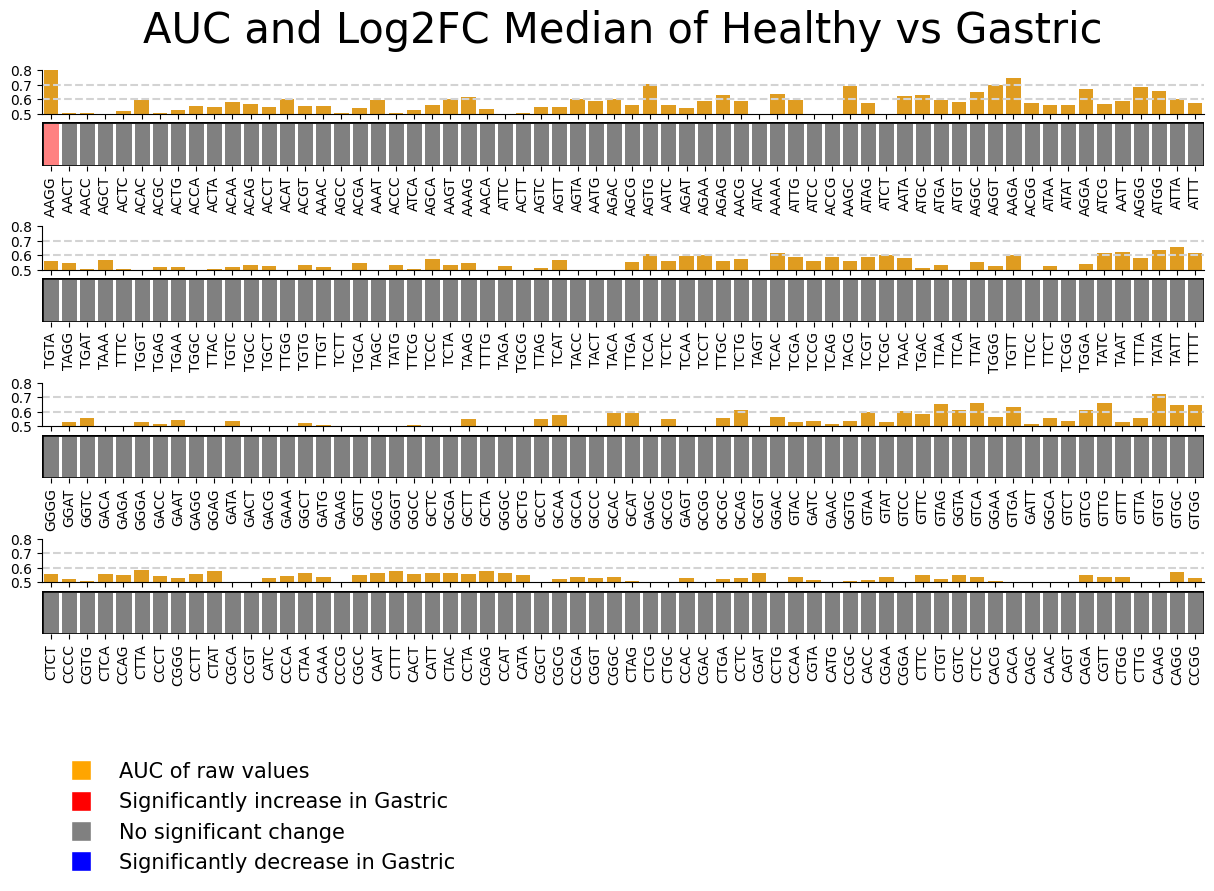

In [3371]:
# data=result.sort_values(by=['nu_start','PlusMinus_Log2FC_'+p.split('-')[0]+'_'+p.split('-')[1],'ABS_Log2FC_'+p.split('-')[0]+'_'+p.split('-')[1]],ascending=True)
data=result.sort_values(by=['nu_start_order','Sig','Log2FC_+-','ABS Log2FC Median of '+p,],ascending=True)
# data=result
# cols=['Mean_F_Healthy','Mean_M_Healthy']
lst_PDAJ=list(data[data['PADJ of '+p.split(' vs ')[0]+' vs '+p.split(' vs ')[1]]<0.05]['FEATURES'])
set1=lst_PDAJ
# for n in [1,2,3,4,5,6,7,8]:
fig, axs = plt.subplots(12, 1, figsize=(15, 8))

for n in [1,2,3,4]:
        # A=data[cols][32*(n-1):32*n].T
        # A=data[['Mean of '+p.split(' vs ')[0],'Mean of '+p.split(' vs ')[1]]][64*(n-1):64*n].T
        # cmap = matplotlib.colormaps["Greens"]
        #         # Set the under color to white
        #         # cmap.set_under("yellow")
        #         # # Set the voer color to white
        #         # cmap.set_over("black")
        # # Set the background color
        # plt.figure(figsize=(15,1))
        # g = sb.heatmap(A,
        #                 # vmin=0,
        #                 # vmax=0.0125,
        #                 cmap=cmap,
        #                 # mask=mask_array,
        #                 yticklabels=True,
        #                 linewidths=2)
        # Set color of masked region
        # g.set_facecolor('gray')
        # if n==1: plt.title(col)
        # plt.title(col)

        lst_out=[]
        for i in list(np.arange(64*(n-1),64*n)):
                # if data['FEATURES'].iloc[i] not in lst_PDAJ:
                if data['FEATURES'].iloc[i] not in set(stats_fea['EM'][stats_fea['EM']['PADJ of '+p]<0.05]['FEATURES']):
                        lst_out+=[i-64*(n-1)]


        col = 'Log2FC Median of '+p.split(' vs ')[0]+' vs '+p.split(' vs ')[1]




        B = data[[col]][64*(n-1):64*n].T
        B.index=[B.columns[0][0]]
        mask_array = np.zeros((1, 64), dtype=bool)
        mask_array[:, lst_out] = True
        cmap = matplotlib.colormaps["seismic"]
        # Set the under color to white
        # cmap.set_under("yellow")
        # # Set the voer color to white
        # cmap.set_over("black")
        # Set the background color
        # plt.figure(figsize=(15,0.7))
        # cbar=True if n==1 else False
        g = sb.heatmap(B,
                        # vmin=-max([abs(min(data[col])),abs(max(data[col]))]),
                        # vmax=max([abs(min(data[col])),abs(max(data[col]))]),
                        vmin=-0.16,
                        vmax=0.16,
                        cmap=cmap,
                        mask=mask_array,
                        yticklabels=False,
                        linewidths=2,
                        # linecolor='black',
                        cbar=False,
                        # cbar_kws={'shrink': 1, 'fraction': 0.5, 'pad': 0.03},
                        # ax=axs[n-1])
                        # ax=axs[2*n-1])
                        ax=axs[(n-1)*3+1])
        # Set color of masked region
        g.set_facecolor('gray')
        # plt.title(col)ax.axhline(y=0, color='k',linewidth=10)
        g.axhline(y=0, color='k',linewidth=2)
        g.axhline(y=1, color='k',linewidth=2)
        g.axvline(x=0, color='k',linewidth=2)
        g.axvline(x=64, color='k',linewidth=2)
        for labe in g.get_xticklabels():
                text = 'EM_'+labe.get_text()
                #if text in overlap012:
                #        labe.set_color('magenta')
                #elif text in overlap01:
                #        labe.set_color('g')



        g1=sb.barplot(data=data[['FEATURES','AUCADJ of '+p]][64*(n-1):64*n],x='FEATURES',y='AUCADJ of '+p,
                #       ax=axs[2*n-2],
                      ax=axs[(n-1)*3],
                      palette=['orange'])
        g1.axhline(y=0.6,ls='--',color='lightgray')
        g1.axhline(y=0.7,ls='--',color='lightgray')
        g1.spines['top'].set_visible(False)
        g1.spines['right'].set_visible(False)
        g1.tick_params(axis='x', labelrotation=90,labelbottom=False)
        g1.set_xlabel('')
        g1.set_ylabel('')
        g1.set_yticks([0.5,0.6,0.7,0.8])
        # sb.despine(left=True)
        g1.set_xlim(left=-0.5)
        g1.set_ylim([0.5,0.8])

        if n==1: g1.set_title('AUC and '+col,pad=20,fontsize=30)

        axs[(n-1)*3+2].axis('off')
plt.tight_layout()
custom_lines = [Line2D([0], [0],marker='s', color='w', markerfacecolor='orange', markersize=15),
        Line2D([0], [0],marker='s', color='w', markerfacecolor='r', markersize=15),
                Line2D([0], [0],marker='s', color='w', markerfacecolor='gray', markersize=15),
                    Line2D([0], [0],marker='s', color='w', markerfacecolor='b', markersize=15),
                    ]
plt.legend(custom_lines,['AUC of raw values','Significantly increase in '+p.split(' vs ')[1],'No significant change','Significantly decrease in '+p.split(' vs ')[1]],loc='upper left',fontsize=15, bbox_to_anchor=(0, -1.3),frameon=False)
# plt.savefig('.\Figure\EM.png', dpi=600, bbox_inches='tight')
plt.subplots_adjust(hspace=0.2)

EM top sig

In [3372]:
#stats_fea['EM'].sort_values(by='Log2FC Median of '+p).reset_index(drop=True).head(5)[['PADJ of '+PAIR[0],'PADJ of '+PAIR[1],'PADJ of '+PAIR[2]]]
stats_fea['EM'].sort_values(by='Log2FC Median of '+p).reset_index(drop=True).head(5)[['PADJ of '+PAIR[0]]]

,PADJ of Healthy vs Gastric
0,0.987355
1,0.987355
2,0.987355
3,0.987355
4,0.987355


In [3373]:
stats_fea['EM'].sort_values(by='Log2FC Median of '+p,ascending=False).reset_index(drop=True)

,FEATURES,Mean of Healthy,Mean of Gastric,Median of Healthy,Median of Gastric,SD of Healthy,SD of Gastric,CV% of Healthy,CV% of Gastric,Entropy of Healthy,...,Log2FC of Healthy vs Gastric,Log2FC Median of Healthy vs Gastric,P of Healthy vs Gastric,PADJ of Healthy vs Gastric,Round_Mean of Healthy,Round_Mean of Gastric,-log10(p-value) of Healthy vs Gastric,Distance of Healthy vs Gastric,AUC of Healthy vs Gastric,AUCADJ of Healthy vs Gastric
0,EM_ATTT,0.003981,0.004086,0.003910,0.004123,0.000407,0.000356,10.211148,8.723558,2.277625,...,0.037470,0.076650,0.329177,0.987355,0.00,0.00,0.005527,1.047623e-04,0.573333,0.573333
1,EM_ATTA,0.001983,0.002038,0.001956,0.002051,0.000168,0.000120,8.452734,5.896290,2.433696,...,0.039668,0.068489,0.164609,0.987355,0.00,0.00,0.005527,5.527897e-05,0.604444,0.604444
2,EM_TTTT,0.005178,0.005373,0.005223,0.005463,0.000509,0.000472,9.821228,8.782374,2.104112,...,0.053429,0.064741,0.124151,0.987355,0.01,0.01,0.005527,1.953448e-04,0.615556,0.615556
3,EM_ATGG,0.001244,0.001281,0.001235,0.001286,0.000073,0.000081,5.884854,6.340236,2.341276,...,0.042992,0.057958,0.039876,0.840139,0.00,0.00,0.075649,3.761803e-05,0.654444,0.654444
4,EM_TATT,0.007828,0.008149,0.007980,0.008302,0.000655,0.000521,8.367958,6.389983,2.256375,...,0.058043,0.057059,0.032054,0.840139,0.01,0.01,0.075649,3.213559e-04,0.661111,0.661111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,EM_TCAG,0.003268,0.003206,0.003272,0.003114,0.000344,0.000433,10.517623,13.512303,2.231415,...,-0.027453,-0.071563,0.236907,0.987355,0.00,0.00,0.005527,-6.159017e-05,0.411111,0.588889
252,EM_TACG,0.000378,0.000377,0.000379,0.000361,0.000035,0.000041,9.311907,10.743820,2.247889,...,-0.004009,-0.072677,0.416136,0.987355,0.00,0.00,0.005527,-1.049033e-06,0.438889,0.561111
253,EM_TCGT,0.000132,0.000132,0.000134,0.000127,0.000013,0.000017,9.690133,12.594954,2.029134,...,-0.006521,-0.074865,0.248834,0.987355,0.00,0.00,0.005527,-5.972667e-07,0.413333,0.586667
254,EM_TCGC,0.000098,0.000096,0.000097,0.000092,0.000011,0.000014,11.028700,14.828292,2.109260,...,-0.017325,-0.078872,0.180900,0.987355,0.00,0.00,0.005527,-1.164600e-06,0.399444,0.600556


In [3374]:
EM_top=list(stats_fea['EM'].sort_values(by='Log2FC Median of '+p).reset_index(drop=True)['FEATURES'][0:5])+list(stats_fea['EM'].sort_values(by='Log2FC Median of '+p,ascending=False).reset_index(drop=True)['FEATURES'][0:5])
EM_top

['EM_GCAG',
 'EM_TCGC',
 'EM_TCGT',
 'EM_TACG',
 'EM_TCAG',
 'EM_ATTT',
 'EM_ATTA',
 'EM_TTTT',
 'EM_ATGG',
 'EM_TATT']

In [3375]:
f='EM'
vector=[]
for s in list(DATA[f]['SampleID']):
    if s in list(sample_list['SampleID']):
        vector+=[True]
    else:
        vector+=[False]
data=DATA[f][vector]
labels=[]
for s in list(data['SampleID']):
    labels+=[list(sample_list[sample_list['SampleID']==s]['Label'])[0]]
data.insert(loc=1,column='Label',value=labels)
data.sort_values(by='SampleID',inplace=True)
data.reset_index(drop=True,inplace=True)
EM_plot1=data[['Label']+EM_top[0:5]].melt(id_vars="Label")
EM_plot1['x']=EM_plot1.apply(lambda r: r['variable'][3:]+'_'+str(int(r['Label'])),axis=1)
EM_plot1.sort_values(by='x',inplace=True)
EM_plot1

,Label,variable,value,x
0,0,EM_GCAG,0.004183,GCAG_0
29,0,EM_GCAG,0.004859,GCAG_0
28,0,EM_GCAG,0.003975,GCAG_0
27,0,EM_GCAG,0.004393,GCAG_0
26,0,EM_GCAG,0.004182,GCAG_0
...,...,...,...,...
152,1,EM_TCGT,0.000155,TCGT_1
151,1,EM_TCGT,0.000124,TCGT_1
178,1,EM_TCGT,0.000128,TCGT_1
163,1,EM_TCGT,0.000133,TCGT_1


In [3376]:
EM_plot2=data[['Label']+EM_top[5:10]].melt(id_vars="Label")
EM_plot2

,Label,variable,value
0,0,EM_ATTT,0.004422
1,0,EM_ATTT,0.004456
2,0,EM_ATTT,0.004674
3,0,EM_ATTT,0.004144
4,0,EM_ATTT,0.003634
...,...,...,...
295,1,EM_TATT,0.008494
296,1,EM_TATT,0.008515
297,1,EM_TATT,0.008249
298,1,EM_TATT,0.006791


Text(-1.1, -0.0065, '**  p-value < 0.05')

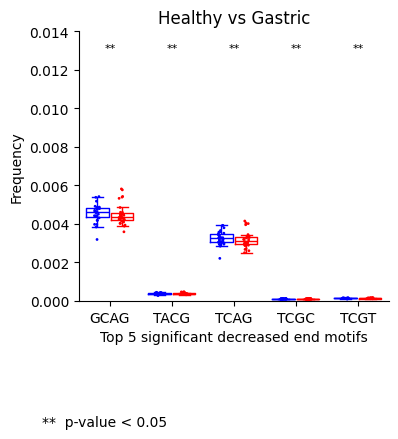

In [3377]:
plt.figure(figsize=(4,3.5))
sb.boxplot(data=EM_plot1,y='value',x='variable',hue='Label',
           palette=['b','r'],hue_order=[0,1],fill=False,linewidth=1,
           flierprops=dict(marker='.',markersize=3),
           showfliers=False,legend=False,
           dodge=True,width=0.8,gap=0.1)
sb.stripplot(data=EM_plot1,y='value',x='variable',hue='Label',
             palette=['b','r'],hue_order=[0,1],
             marker='.',size=4,linewidth=0,legend=False,
             dodge=True
             )
plt.yticks(np.arange(0,0.016,0.002))
plt.ylim(0,0.014)
plt.xticks(ticks=[0,1,2,3,4],labels=[em.split('_')[1] for em in list(EM_plot1['variable'].unique())])
plt.ylabel('Frequency')
plt.xlabel('Top 5 significant decreased end motifs')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
custom_lines = [
                    # Line2D([0], [0], color='w', lw=0, marker='*', markersize=00),
                    Line2D([0], [0],marker='s', color='b', markerfacecolor='w', markersize=5),     
                    Line2D([0], [0],marker='s', color='r', markerfacecolor='w', markersize=5),
                    ]
# plt.legend(custom_lines,['p-value < 0.00001','Control (n=168)','Lung cancer (n=99)'],bbox_to_anchor=(1.3, .8),loc='center right',frameon=False)
# plt.legend(custom_lines,['Control (n=168)','Lung cancer (n=99)'],bbox_to_anchor=(1.05, .1),loc='center right',frameon=False)

plt.text(x=0,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=1,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=2,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=3,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=4,y=0.013,s='**',ha='center',fontsize=8)
plt.title(p)
# plt.text(x=4.7,y=0.007,s='**',fontsize=8)
# plt.savefig('.\Figure/EM_top5_1.png',dpi=600,bbox_inches='tight')
plt.title(p)
plt.text(x=-1.1,y=-0.0065,s='**  p-value < 0.05')

Text(-1.1, -0.0065, '**  p-value < 0.05')

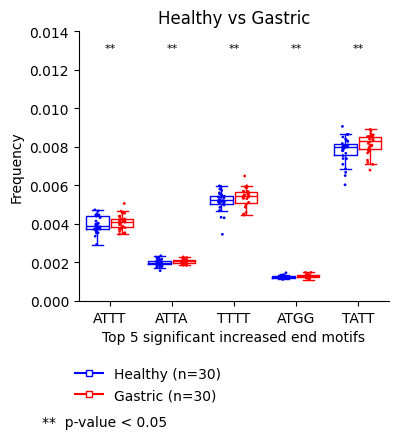

In [3378]:
plt.figure(figsize=(4,3.5))
sb.boxplot(data=EM_plot2,y='value',x='variable',hue='Label',
           palette=['b','r'],hue_order=[0,1],fill=False,linewidth=1,
           flierprops=dict(marker='.',markersize=3),
           showfliers=False,
           dodge=True,width=0.8,gap=0.1)
sb.stripplot(data=EM_plot2,y='value',x='variable',hue='Label',
             palette=['b','r'],hue_order=[0,1],
             marker='.',size=4,linewidth=0,
             dodge=True
             )
plt.yticks(np.arange(0,0.016,0.002))
plt.ylim(0,0.014)
plt.xticks(ticks=[0,1,2,3,4],labels=[em.split('_')[1] for em in list(EM_plot2['variable'].unique())])
plt.ylabel('Frequency')
plt.xlabel('Top 5 significant increased end motifs')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
custom_lines = [
                    # Line2D([0], [0], color='w', lw=0, marker='*', markersize=00),
                    Line2D([0], [0],marker='s', color='b', markerfacecolor='w', markersize=5),     
                    Line2D([0], [0],marker='s', color='r', markerfacecolor='w', markersize=5),
                    ]
# plt.legend(custom_lines,['p_value < 0.00001','Healthy','Lung'],bbox_to_anchor=(1, .8),frameon=False)
# plt.legend(custom_lines,['Control \n(n=168)','Lung cancer \n(n=99)'],bbox_to_anchor=(1.45, .8),loc='center right',frameon=False)
tys=[p.split(' vs ')[0]+' (n='+str(len(SAMPLES[p.split(' vs ')[0]]))+')',
     p.split(' vs ')[1]+' (n='+str(len(SAMPLES[p.split(' vs ')[1]]))+')']
plt.legend(custom_lines,tys,frameon=False,loc='upper right', bbox_to_anchor=(0.5, -0.2))
plt.text(x=0,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=1,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=2,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=3,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=4,y=0.013,s='**',ha='center',fontsize=8)
# plt.text(x=4.7,y=0.0021,s='*****',fontsize=8)
# plt.savefig('.\Figure/EM_top5_2.png',dpi=600,bbox_inches='tight')
plt.title(p)
plt.text(x=-1.1,y=-0.0065,s='**  p-value < 0.05')

In [3379]:
# for

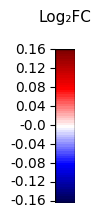

In [3380]:
a=0.16
step1=0.005
Cbar=pd.DataFrame({u'log\u2082(fold change)':np.arange(a,-(a+step1),-step1)})
Cbar.index=[round(x,2) for x in Cbar[u'log\u2082(fold change)']]
plt.figure(figsize=(0.25,2))
Cbar_g=sb.heatmap(Cbar,
           cbar=False,
           cmap = matplotlib.colormaps["seismic"],
           xticklabels=False,
           )
labels=[round(i,2) for i in np.arange(a,-(a+0.04),-0.04)]
step=(len(Cbar)-1)/(len(labels)-1)
ticks=list(np.arange(0,len(Cbar),step))
plt.yticks(ticks=ticks,labels=labels)
plt.title(u'Log\u2082FC',pad=20,fontsize=11)
Cbar_g.axhline(y=0, color='k',linewidth=1)
Cbar_g.axhline(y=len(Cbar), color='k',linewidth=1)
Cbar_g.axvline(x=0, color='k',linewidth=1)
Cbar_g.axvline(x=1, color='k',linewidth=1)

FLEN distribution

In [3381]:
f='FLEN'

In [3382]:
#df=stats_fea[f]
#a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]>=0)]['FEATURES'])
#b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]>=0)]['FEATURES'])
#c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]>=0)]['FEATURES'])
#plt.figure(figsize=(3,3))
#matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
#plt.title(f+" \nIncerease in cancer")
#overlap01=list(a&b-c)
#overlap012=list(a&b&c)

#df=stats_fea[f]
#a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]<0)]['FEATURES'])
#b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]<0)]['FEATURES'])
#c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]<0)]['FEATURES'])
#plt.figure(figsize=(3,3))
#matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
#plt.title(f+" \nDecerease in cancer")
#overlap01=list(a&b-c)
#overlap012=list(a&b&c)

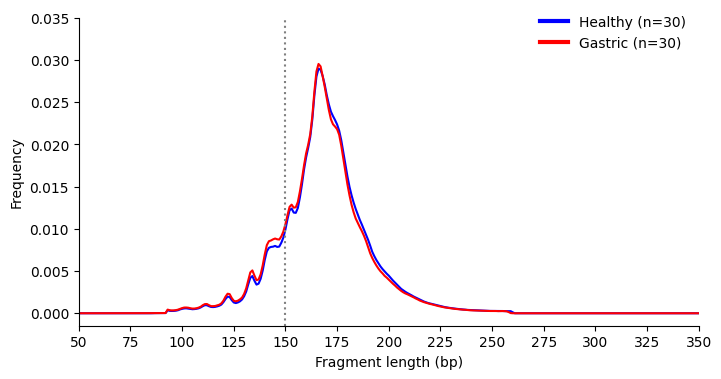

In [3383]:
G={
    'Healthy':'b',
    #'Gastric_benign':'g',
    'Gastric':'r'
    }
plt.figure(figsize=(8,4))
custom_lines=[]
# x=np.arange(100,251,1)
x=np.arange(50,351,1)

for g in list(G.keys()):
    y1=stats_fea['FLEN']['Median of '+g]
    sb.lineplot(x=x,y=y1,color=G[g],lw=1.5)
    custom_lines += [Line2D([0], [0], color=G[g], lw=3)]

plt.axvline(x=150, color='gray', label='axvline - full height',ls=':')
tys=['Healthy (n='+str(len(SAMPLES['Healthy']))+')',
    # 'Gastric_benign (n='+str(len(SAMPLES['Gastric_benign']))+')',
     'Gastric (n='+str(len(SAMPLES['Gastric']))+')']
plt.legend(custom_lines,tys,bbox_to_anchor=(1, 1.05),frameon=False)
plt.ylabel('Frequency')
plt.xlabel('Fragment length (bp)')
# plt.xticks(np.arange(100,275,25))
plt.xlim(50,350)
plt.xticks(np.arange(50,375,25))
plt.yticks(np.arange(0,0.04,0.005))
# plt.title('Fragment length distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig('.\Figure/FLEN_50-350_distribution.png', dpi=600, bbox_inches='tight')

In [3384]:
#G2={
#    'Healthy':'blue',
#    'Gastric_benign':'g',
#    'Gastric':'r'
#    }
#plt.figure(figsize=(8,4))
#custom_lines=[Line2D([0], [0], color='b', lw=3),
#              Line2D([0], [0], color='g', lw=3),
#              Line2D([0], [0], color='r', lw=3)]
#vector=[]
#for s in list(DATA[f]['SampleID']):
#    if s in list(sample_list_all['SampleID']):
#        vector+=[True]
#    else:
#        vector+=[False]
#data=DATA[f][vector]
#labels=[]
#for s in list(data['SampleID']):
#    labels+=[list(sample_list_all[sample_list_all['SampleID']==s]['Type'])[0]]
#data.insert(loc=1,column='Type',value=labels)
#data.sort_values(by='Type',ascending=False)
#data.reset_index(drop=True,inplace=True)

#x=np.arange(50,351,1)
#for i in range(len(data)):
#    g=data['Type'][i]
#    y2=data.iloc[i,2:]
#    sb.lineplot(x=x,y=y2,color=G2[g],lw=1)
#plt.legend(custom_lines,['Healthy','Gastric_benign','Gastric'],bbox_to_anchor=(1, 1.05),frameon=False)
#plt.ylabel('Frequency')
#plt.xlabel('Fragment length (bp)')
#plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['right'].set_visible(False)
#plt.axvline(x=150, color='gray', label='axvline - full height',ls=':')
# sb.lineplot(x=x,y=stats_fea['FLEN100']['Mean of Lung'],color='b',lw=2)
# sb.lineplot(x=x,y=stats_fea['FLEN100']['Mean of Healthy'],color='r',lw=2)
# plt.title(fea['FLEN100']['SampleID'][r])
#plt.yticks(np.arange(0,0.045,0.005))
#plt.xticks(np.arange(50,375,25))

In [3385]:
#df=pd.DataFrame(data[data['Type']=='Healthy'])[['SampleID','FLEN_200']].sort_values(by='FLEN_200')
#df


In [3386]:
#special_sample='KGDAAA09'
#G2={
#    'Healthy':'blue',
#    'Gastric_benign':'g',
#    'Gastric':'r'
#    }
#plt.figure(figsize=(8,4))
#custom_lines=[Line2D([0], [0], color='b', lw=3),
#              Line2D([0], [0], color='g', lw=3),
#              Line2D([0], [0], color='r', lw=3)]
#vector=[]
#for s in list(DATA[f]['SampleID']):
#    if s in list(sample_list_all['SampleID']):
#        vector+=[True]
#    else:
#        vector+=[False]
#data=DATA[f][vector]
#labels=[]
#for s in list(data['SampleID']):
#    labels+=[list(sample_list_all[sample_list_all['SampleID']==s]['Type'])[0]]
#data.insert(loc=1,column='Type',value=labels)
#data.sort_values(by='Type',ascending=False)
#data.reset_index(drop=True,inplace=True)

#x=np.arange(50,351,1)
#for i in range(len(data)):
#    g=data['Type'][i]
#    y2=data.iloc[i,2:]
#    if data['SampleID'][i]==special_sample:
#        sb.lineplot(x=x,y=y2,color=G2[g],lw=1)
#plt.legend(custom_lines,['Healthy','Gastric_benign','Gastric'],bbox_to_anchor=(1, 1.05),frameon=False)
#plt.ylabel('Frequency')
#plt.xlabel('Fragment length (bp)')
#plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['right'].set_visible(False)
#plt.axvline(x=150, color='gray', label='axvline - full height',ls=':')
# sb.lineplot(x=x,y=stats_fea['FLEN100']['Mean of Lung'],color='b',lw=2)
# sb.lineplot(x=x,y=stats_fea['FLEN100']['Mean of Healthy'],color='r',lw=2)
#plt.title(special_sample)
#plt.yticks(np.arange(0,0.045,0.005))
#plt.xticks(np.arange(50,375,25))

In [3387]:
#G={
#    'Healthy':'b',
#    'Gastric_benign':'g',
#    'Gastric':'r'
#    }
#plt.figure(figsize=(8,4))
#custom_lines=[]
# x=np.arange(100,251,1)
#x=np.arange(50,351,1)

#for g in list(G.keys()):
#    y1=stats_fea['FLEN']['Median of '+g]
#    sb.lineplot(x=x,y=y1,color=G[g],lw=1.5)
#    custom_lines += [Line2D([0], [0], color=G[g], lw=3)]

#plt.axvline(x=150, color='gray', label='axvline - full height',ls=':')
#tys=['Healthy (n='+str(len(SAMPLES['Healthy']))+')',
#     'Gastric_benign (n='+str(len(SAMPLES['Gastric_benign']))+')',
#     'Gastric (n='+str(len(SAMPLES['Gastric']))+')']
#plt.legend(custom_lines,tys,bbox_to_anchor=(1, 1.05),frameon=False)
#plt.ylabel('Frequency')
#plt.xlabel('Fragment length (bp)')
# plt.xticks(np.arange(100,275,25))
#plt.xticks(np.arange(50,375,25))
#plt.xlim(100,250)
#plt.yticks(np.arange(0,0.04,0.005))
# plt.title('Fragment length distribution')
#plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['right'].set_visible(False)
# plt.savefig('.\Figure/FLEN_50-350_distribution.png', dpi=600, bbox_inches='tight')

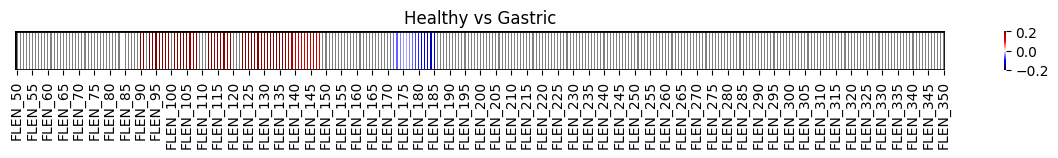

In [3388]:
for p in PAIR:
    df=stats_fea['FLEN']
    set_Overlap=df[df['PADJ of '+p]<=0.05]['FEATURES']
    # df.index=df.apply(lambda row: row['FEATURES'].split('_')[1],axis=1)
    df.index=df.apply(lambda row: row['FEATURES'],axis=1)
    lst_in_out=[]
    for i in range(len(df['FEATURES'])):
        if df['FEATURES'].iloc[i] not in list(set_Overlap):
            lst_in_out+=[i]
    len(lst_in_out)

    A = df[['Log2FC Median of '+p]].T
    mask_array = np.zeros((1, df.shape[0]), dtype=bool)
    mask_array[:, lst_in_out] = True
    cmap = matplotlib.colormaps["seismic"]
    # Set the under color to white
    # cmap.set_under("yellow")
    # # Set the voer color to white
    # cmap.set_over("black")
    # Set the background color
    plt.figure(figsize=(15,0.5))
    g = sb.heatmap(A,
                    # vmin=-max([abs(min(df[col])),abs(max(df[col]))]),
                    # vmax=max([abs(min(df[col])),abs(max(df[col]))]),
                   vmin=-0.2,vmax=0.2,
                   cmap=cmap, mask=mask_array,yticklabels=False,
                   cbar=True,linewidths=0.003,linecolor='w',
                #    cbar_kws={'label': u'log\u2082(fold change)'}
                )
    # Set color of masked region
    g.set_facecolor('gray')
    g.axhline(y=0, color='k',linewidth=2)
    g.axhline(y=1, color='k',linewidth=2)
    g.axvline(x=0, color='k',linewidth=2)
    g.axvline(x=301, color='k',linewidth=2)
    g.set_title(p)
    # colorbar = g.collections[0].colorbar
    # colorbar.set_label('Colorbar Title', fontsize=12, labelpad=10)
    # colorbar.ax.invert_yaxis()
    # colorbar.set_label(u'log\u2082(fold change)', fontsize=12, rotation=0)
    # plt.title(p)
    # plt.savefig('.\Figure/FLEN_50-350_heatmap.png', dpi=600, bbox_inches='tight')

NFP distribution

In [3389]:
f='NFP'

In [3390]:
#df=stats_fea[f]
#a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]>=0)]['FEATURES'])
#b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]>=0)]['FEATURES'])
#c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]>=0)]['FEATURES'])
#plt.figure(figsize=(3,3))
#matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
#plt.title(f+" \nIncerease in cancer")
#overlap01=list(a&b-c)
#overlap012=list(a&b&c)

#df=stats_fea[f]
#a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]<0)]['FEATURES'])
#b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]<0)]['FEATURES'])
#c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]<0)]['FEATURES'])
#plt.figure(figsize=(3,3))
#matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
#plt.title(f+" \nDecerease in cancer")
#overlap01=list(a&b-c)
#overlap012=list(a&b&c)

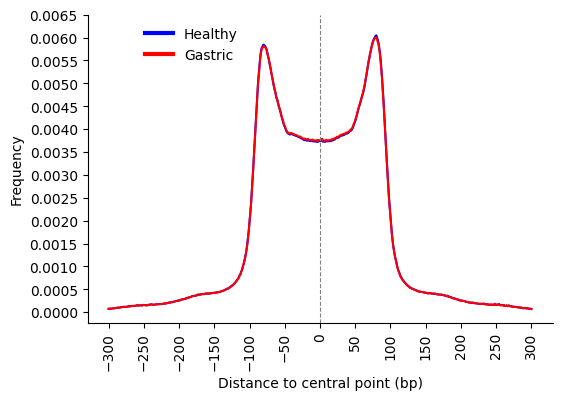

In [3391]:
G={
    'Healthy':'b',
    #'Gastric_benign':'g',
    'Gastric':'r'
    }
plt.figure(figsize=(6,4))
custom_lines=[]
x=np.arange(-300,301,1)

for g in list(G.keys()):
    y1=stats_fea['NFP']['Median of '+g]
    ax=sb.lineplot(x=x,y=y1,color=G[g])
    custom_lines += [Line2D([0], [0], color=G[g], lw=3)]

plt.legend(custom_lines,G,bbox_to_anchor=(0.35, 1.),frameon=False)
plt.ylabel('Frequency')
plt.yticks(np.arange(0,0.007,0.0005))
plt.xlabel('Distance to central point (bp)')
plt.xticks(np.arange(-300,350,50),rotation=90)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(x=0, color='gray', label='axvline - full height',ls='--',lw=0.8)

# plt.axvline(x=-90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axvline(x=90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0035-0.00011, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0065, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')

# plt.savefig('.\Figure/NFP_distribution.png', dpi=600, bbox_inches='tight')

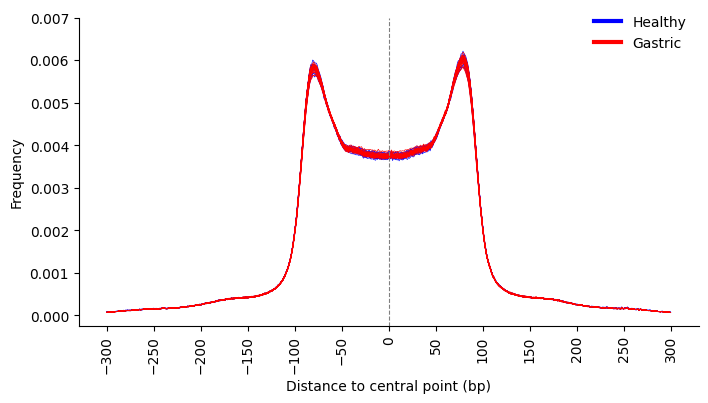

In [3392]:
G2={
    'Healthy':'blue',
    'Gastric':'r',
    #'Gastric_benign':'g',   
    }
plt.figure(figsize=(8,4))
custom_lines=[Line2D([0], [0], color='b', lw=3),
              Line2D([0], [0], color='r', lw=3),
              Line2D([0], [0], color='g', lw=3)
              ]
vector=[]
for s in list(DATA[f]['SampleID']):
    if s in list(sample_list_all['SampleID']):
        vector+=[True]
    else:
        vector+=[False]
data=DATA[f][vector]
labels=[]
for s in list(data['SampleID']):
    labels+=[list(sample_list_all[sample_list_all['SampleID']==s]['Type'])[0]]
data.insert(loc=1,column='Type',value=labels)
data.sort_values(by='Type',ascending=False)

order=[]
for s in list(data['SampleID']):
    if list(data[data['SampleID']==s]['Type'])[0]=='Healthy':
        order+=[0]
    elif list(data[data['SampleID']==s]['Type'])[0]=='Gastric':
        order+=[1]
    #elif list(data[data['SampleID']==s]['Type'])[0]=='Gastric_benign':
    #    order+=[2]
data.insert(loc=1,column='order',value=order)
data.sort_values(by='order',ascending=True,inplace=True)          
data.reset_index(drop=True,inplace=True)

x=np.arange(-300,301,1)

# for g in list(G.keys()):
#     y1=stats_fea['NFP']['Mean of '+g]
#     ax=sb.lineplot(x=x,y=y1,color=G[g],lw=2)
#     custom_lines += [Line2D([0], [0], color=G[g], lw=3)]
for i in range(len(data)):
    g=data['Type'][i]
    y2=data.iloc[i,3:]
    sb.lineplot(x=x,y=y2,color=G2[g],lw=0.5)
# sb.lineplot(x=x,y=stats_fea['NFP']['Mean of Lung'],color='b',lw=2)
# sb.lineplot(x=x,y=stats_fea['NFP']['Mean of Healthy'],color='r',lw=2)

#plt.legend(custom_lines,['Healthy','Gastric','Gastric_benign'],bbox_to_anchor=(1, 1.05),frameon=False)
plt.legend(custom_lines,['Healthy','Gastric'],bbox_to_anchor=(1, 1.05),frameon=False)
plt.ylabel('Frequency')
plt.yticks(np.arange(0,0.008,0.001))
plt.xlabel('Distance to central point (bp)')
plt.xticks(np.arange(-300,350,50),rotation=90)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(x=0, color='gray', label='axvline - full height',ls='--',lw=0.8)

# plt.axvline(x=-90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axvline(x=90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0035-0.00011, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0065, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')
# square=patches.Rectangle((0.003, 0.003), 0.006, 0.006, edgecolor='orange', facecolor='none')
# ax.add_patch(square)
# plt.title('Nucleosome footprint partern')
# plt.savefig('.\Figure/NFP_distribution_all.png', dpi=600, bbox_inches='tight')

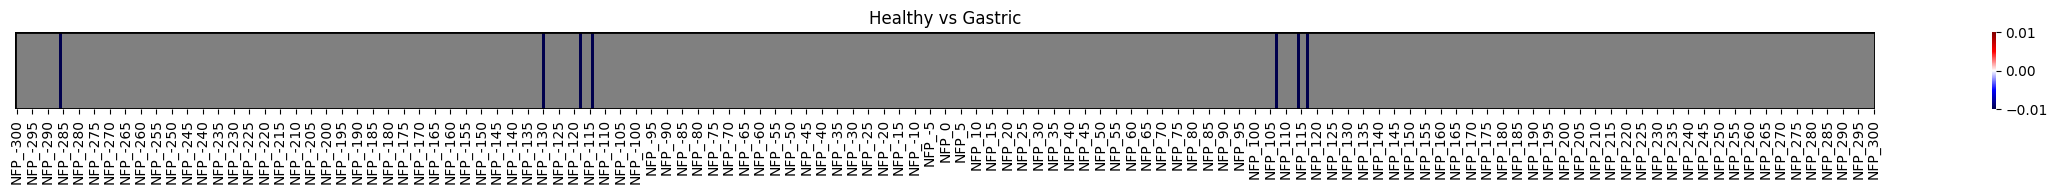

In [3393]:
for p in PAIR:
    df=stats_fea['NFP']
    set_Overlap=df[df['PADJ of '+p]<=0.05]['FEATURES']
    # df.index=df.apply(lambda row: row['FEATURES'].split('_')[1],axis=1)
    df.index=df.apply(lambda row: row['FEATURES'],axis=1)
    lst_in_out=[]
    for i in range(len(df['FEATURES'])):
        if df['FEATURES'].iloc[i] not in list(set_Overlap):
            lst_in_out+=[i]
    len(lst_in_out)

    A = df[['Log2FC Median of '+p]].T
    mask_array = np.zeros((1, df.shape[0]), dtype=bool)
    mask_array[:, lst_in_out] = True
    cmap = matplotlib.colormaps["seismic"]
    # Set the under color to white
    # cmap.set_under("yellow")
    # # Set the voer color to white
    # cmap.set_over("black")
    # Set the background color
    plt.figure(figsize=(30,1))
    g = sb.heatmap(A,
                    # vmin=-max([abs(min(df[col])),abs(max(df[col]))]),
                    # vmax=max([abs(min(df[col])),abs(max(df[col]))]),
                   vmin=-0.01,vmax=0.01,
                   cmap=cmap, mask=mask_array,yticklabels=False,
                   cbar=True,linewidths=0.00,linecolor='w',
                #    cbar_kws={'label': u'log\u2082(fold change)'}
                )
    # Set color of masked region
    g.set_facecolor('gray')
    g.axhline(y=0, color='k',linewidth=2)
    g.axhline(y=1, color='k',linewidth=2)
    g.axvline(x=0, color='k',linewidth=2)
    g.axvline(x=601, color='k',linewidth=2)
    g.set_title(p)
    # colorbar = g.collections[0].colorbar
    # colorbar.set_label('Colorbar Title', fontsize=12, labelpad=10)
    # colorbar.ax.invert_yaxis()
    # colorbar.set_label(u'log\u2082(fold change)', fontsize=12, rotation=0)
    # plt.title(p)
    # plt.savefig('.\Figure/FLEN_50-350_heatmap.png', dpi=600, bbox_inches='tight')

In [3394]:
df=pd.DataFrame(data[data['Type']=='Healthy'])[['SampleID','NFP_75']].sort_values(by='NFP_75')
df

,SampleID,NFP_75
20,HNGH037,0.005736
19,HNGH036,0.005740
26,HNGH062,0.005756
29,HNGH071,0.005781
17,HNGH032,0.005827
27,HNGH064,0.005857
14,HNGH026,0.005859
23,HNGH045,0.005863
4,HNGH006,0.005867
10,HNGH015,0.005876


Text(0.5, 1.0, 'KGDAAA09')

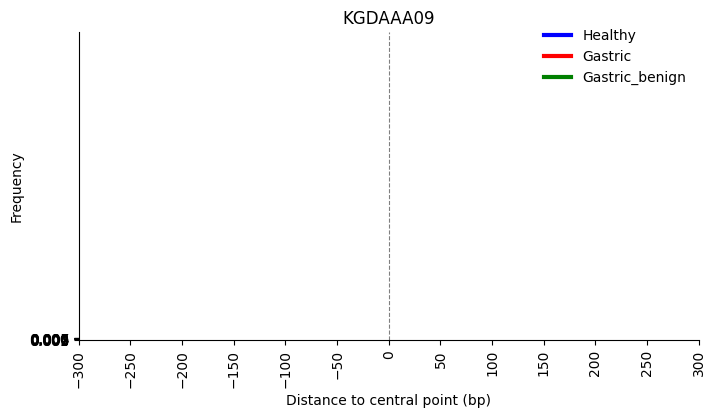

In [3395]:
special_sample='KGDAAA09'
G2={
    'Healthy':'blue',
    'Gastric':'r',
    'Gastric_benign':'g'
    }
plt.figure(figsize=(8,4))
custom_lines=[Line2D([0], [0], color='b', lw=3),
              Line2D([0], [0], color='r', lw=3),
              Line2D([0], [0], color='g', lw=3)
              ]
vector=[]
for s in list(DATA[f]['SampleID']):
    if s in list(sample_list_all['SampleID']):
        vector+=[True]
    else:
        vector+=[False]
data=DATA[f][vector]
labels=[]
for s in list(data['SampleID']):
    labels+=[list(sample_list_all[sample_list_all['SampleID']==s]['Type'])[0]]
data.insert(loc=1,column='Type',value=labels)
data.sort_values(by='Type',ascending=False)

order=[]
for s in list(data['SampleID']):
    if list(data[data['SampleID']==s]['Type'])[0]=='Healthy':
        order+=[0]
    elif list(data[data['SampleID']==s]['Type'])[0]=='Gastric':
        order+=[1]
    elif list(data[data['SampleID']==s]['Type'])[0]=='Gastric_benign':
        order+=[2]
data.insert(loc=1,column='order',value=order)
data.sort_values(by='order',ascending=True,inplace=True)          
data.reset_index(drop=True,inplace=True)

x=np.arange(-300,301,1)

# for g in list(G.keys()):
#     y1=stats_fea['NFP']['Mean of '+g]
#     ax=sb.lineplot(x=x,y=y1,color=G[g],lw=2)
#     custom_lines += [Line2D([0], [0], color=G[g], lw=3)]
for i in range(len(data)):
    g=data['Type'][i]
    y2=data.iloc[i,3:]
    if data['SampleID'][i]==special_sample:
        sb.lineplot(x=x,y=y2,color=G2[g],lw=0.5)
# sb.lineplot(x=x,y=stats_fea['NFP']['Mean of Lung'],color='b',lw=2)
# sb.lineplot(x=x,y=stats_fea['NFP']['Mean of Healthy'],color='r',lw=2)

plt.legend(custom_lines,['Healthy','Gastric','Gastric_benign'],bbox_to_anchor=(1, 1.05),frameon=False)
plt.ylabel('Frequency')
plt.yticks(np.arange(0,0.008,0.001))
plt.xlabel('Distance to central point (bp)')
plt.xticks(np.arange(-300,350,50),rotation=90)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(x=0, color='gray', label='axvline - full height',ls='--',lw=0.8)

# plt.axvline(x=-90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axvline(x=90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0035-0.00011, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0065, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')
# square=patches.Rectangle((0.003, 0.003), 0.006, 0.006, edgecolor='orange', facecolor='none')
# ax.add_patch(square)
plt.title(special_sample)
# plt.savefig('.\Figure/NFP_distribution_all.png', dpi=600, bbox_inches='tight')

CNA bins

In [3396]:
def vectorcolor(p,f):
    data_split=stats_fea[f]
    # data_concatenate=stats_fea['All_features']
    col_PADJ='PADJ of '+p
    col_L2FC='Log2FC of '+p
    cols=[]
    for i in list(data_split.iloc[:,0]):
        PADJ_split=data_split[data_split[data_split.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]
        # PADJ_concatenate=data_concatenate[data_concatenate[data_concatenate.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]

        L2FC_split=data_split[data_split[data_split.columns[0]]==i][col_L2FC].reset_index(drop=True)[0]

        if L2FC_split <0 and PADJ_split<=0.05:
            cols.append('b')
        elif L2FC_split >=0 and PADJ_split<=0.05:
            cols.append('red')
        elif PADJ_split>0.05:
            cols.append('gray')
    return cols

In [3397]:
#Tạo position cho chromosome
Chromosome=[]
for i in range(len(stats_fea['CNA'])):
    chromosome=int(stats_fea['CNA']['FEATURES'].iloc[i].split(":")[0].split("_")[1])
    Chromosome+=[chromosome]
results=pd.DataFrame({'Chromosome':Chromosome})
results=results['Chromosome'].value_counts().sort_index()
results=pd.DataFrame({'Count':results})
lst=[]
for i in range(len(results)):
    # lst+=[sum(results.iloc[:i,0])+round(results.iloc[i,0]/2,0)]
    lst+=[sum(results.iloc[:i+1,0])]
results['Vline']=lst

Position=[]
for i in range(1,23,1):
    if i ==1:
        posit=int(results['Vline'][i]/4)
    else:
        posit=int((results['Vline'][i]+results['Vline'][i-1])/2)
    Position+=[posit]
results['Position']=Position
results

,Count,Vline,Position
Chromosome,,,
1,159,159,39
2,162,321,240
3,148,469,395
4,140,609,539
5,136,745,677
6,120,865,805
7,111,976,920
8,108,1084,1030
9,83,1167,1125


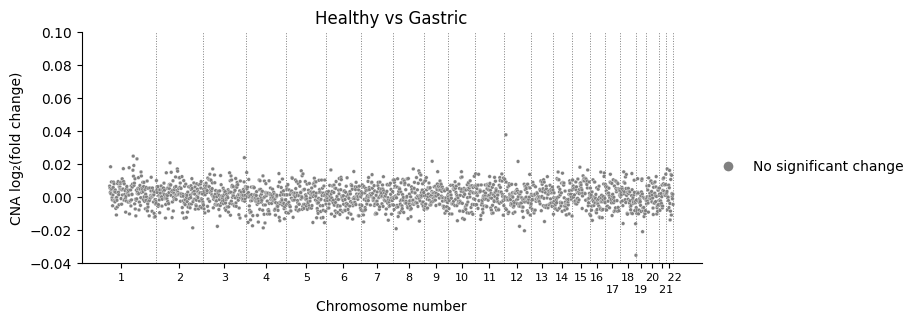

In [3398]:
f='CNA'
custom_lines = [
    # Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=8,mec='w'),
                Line2D([0], [0],marker='o', color='w', markerfacecolor='gray', markersize=8,mec='w'),
                    # Line2D([0], [0],marker='o', color='w', markerfacecolor='b', markersize=8,mec='w'),
                    ]
data=stats_fea[f]
for p in PAIR:
    col_log='Log2FC of '+p
    if col_log not in data.columns:
        col_log='Distance of '+p
    col_PADJ='PADJ of '+p 
    cols=vectorcolor(p,f)

    plt.figure(figsize=(8, 3))
    # plt.figure(figsize=(6/1.4,3/1.5))
    xlabels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','\n17','18','\n19','20','\n  21','   22']
    x=data['FEATURES']
    y=data[col_log]

    for vline in results['Vline']:
        plt.axvline(x=vline, color='gray', label='axvline - full height',ls=':',lw=0.7)
        
    sb.scatterplot(x=x,y=y,c=cols,s=7,edgecolor='w')
    # lst_name_show=["CNA_10:135000001-135534747"]
    # region_name = list(data['FEATURES'])
    # for i, txt in enumerate(region_name):
    #     if txt in lst_name_show:
    #         plt.text(x[i],y[i],txt,fontsize=8,color='red')
   
    
    plt.xticks(ticks=results['Position'],labels=xlabels,fontsize=8)
    plt.yticks(np.arange(-0.04,0.1,0.02))
    plt.xlabel('Chromosome number')
    plt.ylabel('CNA '+u'log\u2082(fold change)')
    plt.title(p)
    # n_gain=pd.DataFrame(cols)[0].value_counts()['red']
    # n_loss=pd.DataFrame(cols)[0].value_counts()['b']
    # plt.legend(custom_lines,['CNA gain (n='+str(n_gain)+')','No significant change','CNA loss (n='+str(n_loss)+')'],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.legend(custom_lines,['No significant change'],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    # plt.legend(custom_lines,['CNA gain (n='+str(n_gain)+')','No significant change','CNA loss (n='+str(n_loss)+')'],loc='upper right', bbox_to_anchor=(0.5, -0.3),frameon=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.savefig('.\Figure\CNA_bins.png', dpi=600, bbox_inches='tight')

SCNA bins

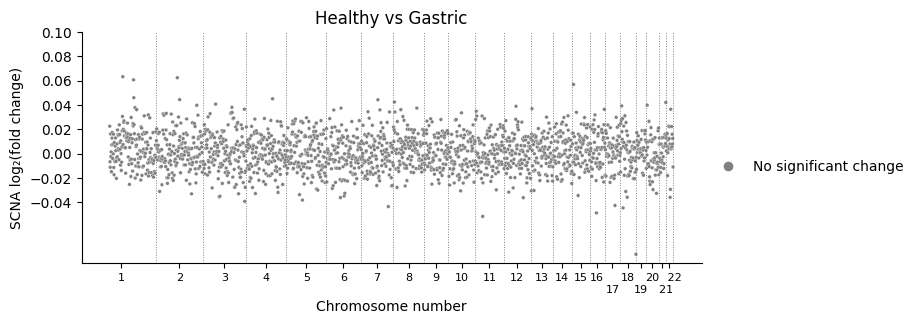

In [3399]:
f='SCNA'
custom_lines = [
    # Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=8,mec='w'),
                Line2D([0], [0],marker='o', color='w', markerfacecolor='gray', markersize=8,mec='w'),
                    # Line2D([0], [0],marker='o', color='w', markerfacecolor='b', markersize=8,mec='w'),
                    ]
data=stats_fea[f]
for p in PAIR:
    col_log='Log2FC of '+p
    if col_log not in data.columns:
        col_log='Distance of '+p
    col_PADJ='PADJ of '+p 
    cols=vectorcolor(p,f)

    plt.figure(figsize=(8, 3))
    # plt.figure(figsize=(6/1.4,3/1.5))
    xlabels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','\n17','18','\n19','20','\n  21','   22']
    x=data['FEATURES']
    y=data[col_log]

    for vline in results['Vline']:
        plt.axvline(x=vline, color='gray', label='axvline - full height',ls=':',lw=0.7)
        
    sb.scatterplot(x=x,y=y,c=cols,s=7,edgecolor='w')
    # lst_name_show=["CNA_10:135000001-135534747"]
    # region_name = list(data['FEATURES'])
    # for i, txt in enumerate(region_name):
    #     if txt in lst_name_show:
    #         plt.text(x[i],y[i],txt,fontsize=8,color='red')
   
    
    plt.xticks(ticks=results['Position'],labels=xlabels,fontsize=8)
    plt.yticks(np.arange(-0.04,0.1,0.02))
    plt.xlabel('Chromosome number')
    plt.ylabel('SCNA '+u'log\u2082(fold change)')
    plt.title(p)
    # n_gain=pd.DataFrame(cols)[0].value_counts()['red']
    # n_loss=pd.DataFrame(cols)[0].value_counts()['b']
    # plt.legend(custom_lines,['CNA gain (n='+str(n_gain)+')','No significant change','CNA loss (n='+str(n_loss)+')'],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.legend(custom_lines,['No significant change'],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    # plt.legend(custom_lines,['CNA gain (n='+str(n_gain)+')','No significant change','CNA loss (n='+str(n_loss)+')'],loc='upper right', bbox_to_anchor=(0.5, -0.3),frameon=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.savefig('.\Figure\CNA_bins.png', dpi=600, bbox_inches='tight')

RATIOSL

In [3400]:
#Tạo position cho chromosome
GWFP=stats_fea['RATIOSL']
GWFP=GWFP[~GWFP['FEATURES'].str.contains('X|Y', case=False, na=False)]
Chromosome=[]
for i in range(len(GWFP)):
    chromosome=GWFP['FEATURES'].iloc[i].split("_")[1].split(':')[0]
    chromosome=int(chromosome)
    Chromosome+=[chromosome]
results=pd.DataFrame({'Chromosome':Chromosome})
results=results['Chromosome'].value_counts().sort_index()
results=pd.DataFrame({'Count':results})
lst=[]
for i in range(len(results)):
    # lst+=[sum(results.iloc[:i,0])+round(results.iloc[i,0]/2,0)]
    lst+=[sum(results.iloc[:i+1,0])]
results['Vline']=lst

Position=[]
for i in range(1,23,1):
    if i ==1:
        posit=int(results['Vline'][i]/4)
    else:
        posit=int((results['Vline'][i]+results['Vline'][i-1])/2)
    Position+=[posit]
results['Position']=Position
results

,Count,Vline,Position
Chromosome,,,
1,230,230,57
2,241,471,350
3,196,667,569
4,190,857,762
5,178,1035,946
6,165,1200,1117
7,158,1358,1279
8,144,1502,1430
9,117,1619,1560


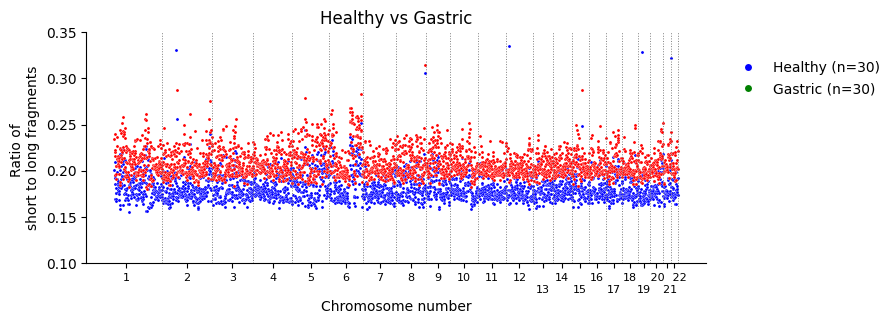

In [3401]:
G['Nongastric']='cyan'
for p in PAIR:
    col1='Mean of '+p.split(" vs ")[0]
    #col2='Mean of '+p.split(" vs ")[1]
    # col_log='Log2FC_'+p 
    # col_PADJ='PADJ_'+p 
    # vectorcolorCNA=[]
    # for i in range(len(stat_GWFP_ratio)):
    #     if stat_CNA[col_PADJ].iloc[i] >= 0.05:
    #         vectorcolorCNA+=['gray']
    #     elif stat_CNA[col_log].iloc[i] > 0:
    #         vectorcolorCNA+=['red']
    #     else:
    #         vectorcolorCNA+=['blue']
    plt.figure(figsize=(8,3))
    for vline in results['Vline']:
        plt.axvline(x=vline, color='gray', label='axvline - full height',ls=':',lw=0.7)
    xlabels=['1','2','3','4','5','6','7','8','9','10','11','12','\n13','14','\n15','16','\n17','18','\n19',' 20','\n  21','   22']
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col1],c=G[p.split(" vs ")[0]],s=5,edgecolor='w')
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col2],c=G[p.split(" vs ")[1]],s=5,edgecolor='w')
    plt.xticks(ticks=results['Position'],labels=xlabels,fontsize=8)
    plt.yticks(np.arange(0.1,0.4,0.05))
    plt.ylim((0.1,0.35))
    plt.xlabel('Chromosome number')
    plt.ylabel('Ratio of \nshort to long fragments')
    plt.title(p)
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='b', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='g', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='cyan', markersize=6,mec='w')]
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper right', bbox_to_anchor=(0.5, -0.3),frameon=False)
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    #plt.legend(custom_lines,['Healthy (n='+str(len(healthy))+')','Gastric_benign (n='+str(len(gastric_benign))+')','Gastric (n='+str(len(gastric))+')','Nongastric (n='+str(len(Nongastric))+')'],loc='center right',bbox_to_anchor=(1.3, 0.8),frameon=True,edgecolor='w')
    plt.legend(custom_lines,['Healthy (n='+str(len(healthy))+')','Gastric (n='+str(len(gastric))+')'],loc='center right',bbox_to_anchor=(1.3, 0.8),frameon=True,edgecolor='w')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.savefig('.\Figure\FLEN_ratio_short_total.png', dpi=600, bbox_inches='tight')

RATIOST

In [3402]:
#Tạo position cho chromosome
GWFP=stats_fea['RATIOST']
GWFP=GWFP[~GWFP['FEATURES'].str.contains('X|Y', case=False, na=False)]
Chromosome=[]
for i in range(len(GWFP)):
    chromosome=GWFP['FEATURES'].iloc[i].split("_")[1].split(':')[0]
    chromosome=int(chromosome)
    Chromosome+=[chromosome]
results=pd.DataFrame({'Chromosome':Chromosome})
results=results['Chromosome'].value_counts().sort_index()
results=pd.DataFrame({'Count':results})
lst=[]
for i in range(len(results)):
    # lst+=[sum(results.iloc[:i,0])+round(results.iloc[i,0]/2,0)]
    lst+=[sum(results.iloc[:i+1,0])]
results['Vline']=lst

Position=[]
for i in range(1,23,1):
    if i ==1:
        posit=int(results['Vline'][i]/4)
    else:
        posit=int((results['Vline'][i]+results['Vline'][i-1])/2)
    Position+=[posit]
results['Position']=Position
# results

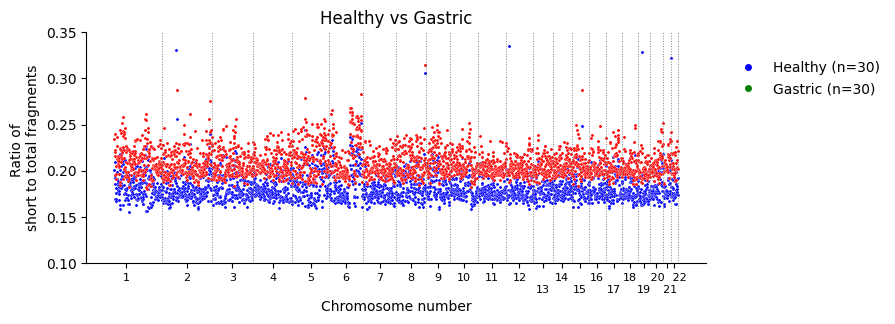

In [3403]:
G['Nongastric']='cyan'
for p in PAIR:
    col1='Mean of '+p.split(" vs ")[0]
    col2='Mean of '+p.split(" vs ")[1]
    # col_log='Log2FC_'+p 
    # col_PADJ='PADJ_'+p 
    # vectorcolorCNA=[]
    # for i in range(len(stat_GWFP_ratio)):
    #     if stat_CNA[col_PADJ].iloc[i] >= 0.05:
    #         vectorcolorCNA+=['gray']
    #     elif stat_CNA[col_log].iloc[i] > 0:
    #         vectorcolorCNA+=['red']
    #     else:
    #         vectorcolorCNA+=['blue']
    plt.figure(figsize=(8,3))
    for vline in results['Vline']:
        plt.axvline(x=vline, color='gray', label='axvline - full height',ls=':',lw=0.7)
    xlabels=['1','2','3','4','5','6','7','8','9','10','11','12','\n13','14','\n15','16','\n17','18','\n19',' 20','\n  21','   22']
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col1],c=G[p.split(" vs ")[0]],s=5,edgecolor='w')
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col2],c=G[p.split(" vs ")[1]],s=5,edgecolor='w')
    plt.xticks(ticks=results['Position'],labels=xlabels,fontsize=8)
    plt.yticks(np.arange(0.1,0.4,0.05))
    plt.ylim((0.1,0.35))
    plt.xlabel('Chromosome number')
    plt.ylabel('Ratio of \nshort to total fragments')
    plt.title(p)
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='b', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='g', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='cyan', markersize=6,mec='w')]
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper right', bbox_to_anchor=(0.5, -0.3),frameon=False)
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    #plt.legend(custom_lines,['Healthy (n='+str(len(healthy))+')','Gastric_benign (n='+str(len(gastric_benign))+')','Gastric (n='+str(len(gastric))+')','Nongastric (n='+str(len(Nongastric))+')'],loc='center right',bbox_to_anchor=(1.3, 0.8),frameon=True,edgecolor='w')
    plt.legend(custom_lines,['Healthy (n='+str(len(healthy))+')','Gastric (n='+str(len(gastric))+')'],loc='center right',bbox_to_anchor=(1.3, 0.8),frameon=True,edgecolor='w')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.savefig('.\Figure\FLEN_ratio_short_total.png', dpi=600, bbox_inches='tight')

In [3404]:
stats_fea['RATIOSL']

,FEATURES,Mean of Healthy,Mean of Gastric,Median of Healthy,Median of Gastric,SD of Healthy,SD of Gastric,CV% of Healthy,CV% of Gastric,Entropy of Healthy,...,Log2FC of Healthy vs Gastric,Log2FC Median of Healthy vs Gastric,P of Healthy vs Gastric,PADJ of Healthy vs Gastric,Round_Mean of Healthy,Round_Mean of Gastric,-log10(p-value) of Healthy vs Gastric,Distance of Healthy vs Gastric,AUC of Healthy vs Gastric,AUCADJ of Healthy vs Gastric
0,RATIOSL_1:1-1000000,0.200876,0.233814,0.198416,0.237219,0.024715,0.040666,12.303574,17.392319,2.413947,...,0.219057,0.257696,0.000927,0.003878,0.20,0.23,2.411405,0.032938,0.748889,0.748889
1,RATIOSL_1:100000001-101000000,0.192497,0.219998,0.188769,0.224457,0.023493,0.042528,12.204427,19.331121,2.354910,...,0.192659,0.249812,0.004128,0.005148,0.19,0.22,2.288325,0.027502,0.715556,0.715556
2,RATIOSL_1:10000001-11000000,0.193999,0.221949,0.193831,0.219578,0.021246,0.039673,10.951512,17.875009,2.453445,...,0.194179,0.179935,0.002104,0.003973,0.19,0.22,2.400921,0.027950,0.731111,0.731111
3,RATIOSL_1:1000001-2000000,0.209911,0.239375,0.208905,0.239281,0.025159,0.040068,11.985483,16.738511,2.418561,...,0.189493,0.195857,0.003940,0.005011,0.21,0.24,2.300094,0.029464,0.716667,0.716667
4,RATIOSL_1:101000001-102000000,0.185574,0.215882,0.183109,0.217732,0.019669,0.038758,10.599024,17.953299,2.413947,...,0.218248,0.249848,0.000710,0.003878,0.19,0.22,2.411405,0.030308,0.754444,0.754444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867,RATIOSL_Y:10000001-11000000,0.234217,0.266006,0.230279,0.259129,0.042149,0.064004,17.995581,24.061029,2.563306,...,0.183618,0.170287,0.076041,0.076254,0.23,0.27,1.117738,0.031790,0.633333,0.633333
2868,RATIOSL_Y:13000001-14000000,0.463372,0.494433,0.416426,0.474299,0.105218,0.124357,22.707051,25.151509,2.216280,...,0.093603,0.187737,0.399389,0.399529,0.46,0.49,0.398452,0.031061,0.563333,0.563333
2869,RATIOSL_Y:58000001-59000000,0.322109,0.363126,0.316528,0.358772,0.048259,0.070774,14.982071,19.490175,2.442118,...,0.172922,0.180733,0.022798,0.022942,0.32,0.36,1.639371,0.041017,0.671111,0.671111
2870,RATIOSL_Y:59000001-59373566,0.202129,0.230132,0.206283,0.224846,0.037682,0.049142,18.642449,21.353629,2.343583,...,0.187190,0.124311,0.034501,0.034645,0.20,0.23,1.460356,0.028004,0.658889,0.658889


In [3405]:
GWFP

,FEATURES,Mean of Healthy,Mean of Gastric,Median of Healthy,Median of Gastric,SD of Healthy,SD of Gastric,CV% of Healthy,CV% of Gastric,Entropy of Healthy,...,Log2FC of Healthy vs Gastric,Log2FC Median of Healthy vs Gastric,P of Healthy vs Gastric,PADJ of Healthy vs Gastric,Round_Mean of Healthy,Round_Mean of Gastric,-log10(p-value) of Healthy vs Gastric,Distance of Healthy vs Gastric,AUC of Healthy vs Gastric,AUCADJ of Healthy vs Gastric
0,RATIOST_1:1-1000000,0.200876,0.233814,0.198416,0.237219,0.024715,0.040666,12.303574,17.392319,2.413947,...,0.219057,0.257696,0.000927,0.003878,0.20,0.23,2.411405,0.032938,0.748889,0.748889
1,RATIOST_1:100000001-101000000,0.192497,0.219998,0.188769,0.224457,0.023493,0.042528,12.204427,19.331121,2.354910,...,0.192659,0.249812,0.004128,0.005148,0.19,0.22,2.288325,0.027502,0.715556,0.715556
2,RATIOST_1:10000001-11000000,0.193999,0.221949,0.193831,0.219578,0.021246,0.039673,10.951512,17.875009,2.453445,...,0.194179,0.179935,0.002104,0.003973,0.19,0.22,2.400921,0.027950,0.731111,0.731111
3,RATIOST_1:1000001-2000000,0.209911,0.239375,0.208905,0.239281,0.025159,0.040068,11.985483,16.738511,2.418561,...,0.189493,0.195857,0.003940,0.005011,0.21,0.24,2.300094,0.029464,0.716667,0.716667
4,RATIOST_1:101000001-102000000,0.185574,0.215882,0.183109,0.217732,0.019669,0.038758,10.599024,17.953299,2.413947,...,0.218248,0.249848,0.000710,0.003878,0.19,0.22,2.411405,0.030308,0.754444,0.754444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,RATIOST_9:95000001-96000000,0.202859,0.232379,0.203511,0.236643,0.021395,0.041090,10.547003,17.682445,2.407235,...,0.196003,0.217606,0.001269,0.003878,0.20,0.23,2.411405,0.029520,0.742222,0.742222
2712,RATIOST_9:96000001-97000000,0.180411,0.203449,0.178168,0.205850,0.020688,0.036632,11.467135,18.005302,2.482213,...,0.173375,0.208357,0.004969,0.005787,0.18,0.20,2.237545,0.023037,0.711111,0.711111
2713,RATIOST_9:97000001-98000000,0.183674,0.211610,0.181553,0.211982,0.021525,0.039234,11.719167,18.540652,2.497347,...,0.204257,0.223557,0.002561,0.004116,0.18,0.21,2.385507,0.027936,0.726667,0.726667
2714,RATIOST_9:98000001-99000000,0.173663,0.201398,0.173335,0.203541,0.021576,0.035525,12.423919,17.639323,2.321527,...,0.213760,0.231756,0.000673,0.003878,0.17,0.20,2.411405,0.027735,0.755556,0.755556


CLE

In [3406]:
#Tạo position cho chromosome
#GWFP=stats_fea['CLE']
#GWFP=GWFP[~GWFP['FEATURES'].str.contains('X|Y', case=False, na=False)]
#Chromosome=[]
#for i in range(len(GWFP)):
#    chromosome=GWFP['FEATURES'].iloc[i].split("_")[1].split(':')[0]
#    chromosome=int(chromosome)
#    Chromosome+=[chromosome]
#results=pd.DataFrame({'Chromosome':Chromosome})
#results=results['Chromosome'].value_counts().sort_index()
#results=pd.DataFrame({'Count':results})
#lst=[]
#for i in range(len(results)):
#    # lst+=[sum(results.iloc[:i,0])+round(results.iloc[i,0]/2,0)]
#    lst+=[sum(results.iloc[:i+1,0])]
#results['Vline']=lst

#Position=[]
#for i in range(1,23,1):
#    if i ==1:
#        posit=int(results['Vline'][i]/4)
#    else:
#        posit=int((results['Vline'][i]+results['Vline'][i-1])/2)
#    Position+=[posit]
#results['Position']=Position
#results

NameError: name 'gastric_benign' is not defined

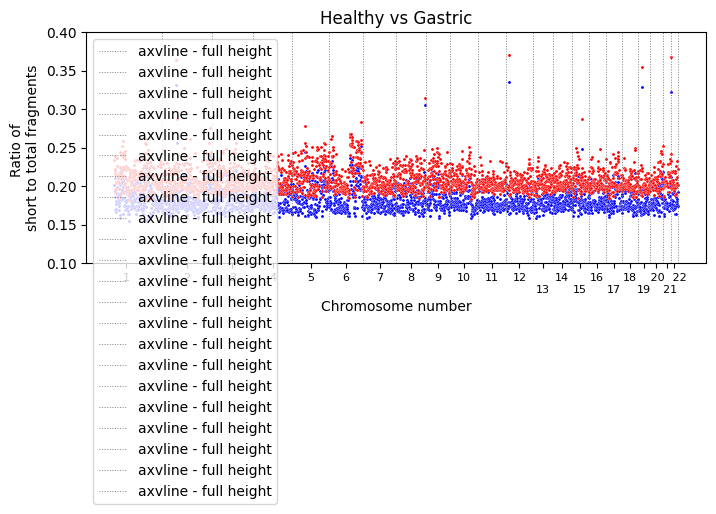

In [3407]:
G['Nongastric']='cyan'
for p in PAIR:
    col1='Mean of '+p.split(" vs ")[0]
    #col2='Mean of '+p.split(" vs ")[1]
    # col_log='Log2FC_'+p 
    # col_PADJ='PADJ_'+p 
    # vectorcolorCNA=[]
    # for i in range(len(stat_GWFP_ratio)):
    #     if stat_CNA[col_PADJ].iloc[i] >= 0.05:
    #         vectorcolorCNA+=['gray']
    #     elif stat_CNA[col_log].iloc[i] > 0:
    #         vectorcolorCNA+=['red']
    #     else:
    #         vectorcolorCNA+=['blue']
    plt.figure(figsize=(8,3))
    for vline in results['Vline']:
        plt.axvline(x=vline, color='gray', label='axvline - full height',ls=':',lw=0.7)
    xlabels=['1','2','3','4','5','6','7','8','9','10','11','12','\n13','14','\n15','16','\n17','18','\n19',' 20','\n  21','   22']
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col1],c=G[p.split(" vs ")[0]],s=5,edgecolor='w')
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col2],c=G[p.split(" vs ")[1]],s=5,edgecolor='w')
    plt.xticks(ticks=results['Position'],labels=xlabels,fontsize=8)
    plt.yticks(np.arange(0.1,0.4,0.05))
    # plt.ylim((0.1,0.35))
    plt.xlabel('Chromosome number')
    plt.ylabel('Ratio of \nshort to total fragments')
    plt.title(p)
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='b', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='g', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='cyan', markersize=6,mec='w')]
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper right', bbox_to_anchor=(0.5, -0.3),frameon=False)
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.legend(custom_lines,['Healthy (n='+str(len(healthy))+')','Gastric_benign (n='+str(len(gastric_benign))+')','Gastric (n='+str(len(gastric))+')','Nongastric (n='+str(len(Nongastric))+')'],loc='center right',bbox_to_anchor=(1.3, 0.8),frameon=True,edgecolor='w')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.savefig('.\Figure\FLEN_ratio_short_total.png', dpi=600, bbox_inches='tight')

PCA

In [ ]:
G={
    'Healthy':'b',
    'Gastric_benign':'g',
    'Gastric':'r'
    }

In [ ]:
special_samples=['KGDAAA09','MG168','ZK0AAAI07NB','ZMG050NB']
special_samples

['KGDAAA09', 'MG168', 'ZK0AAAI07NB', 'ZMG050NB']

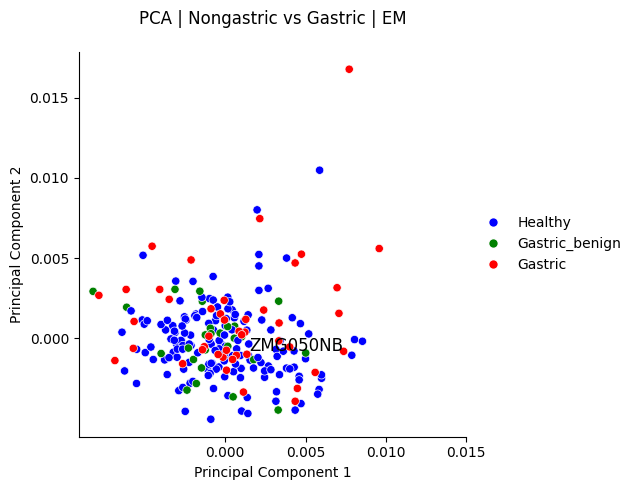

In [ ]:
f='EM'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[0,0.02,0.005],xticks=[0,0.02,0.005],
      save=False,figname='PCA.png'
            )

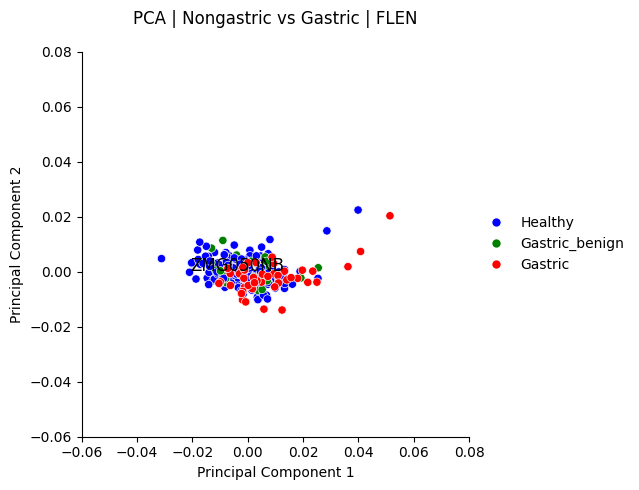

In [ ]:
f='FLEN'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-0.06,0.08,0.02],xticks=[-0.06,0.08,0.02],
      save=False,figname='PCA.png'
            )

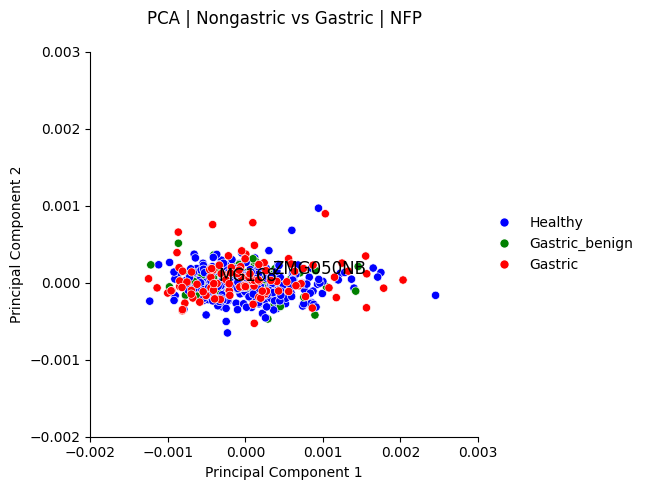

In [ ]:
f='NFP'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-0.002,0.004,0.001],xticks=[-0.002,0.004,0.001],
      save=False,figname='PCA.png'
            )

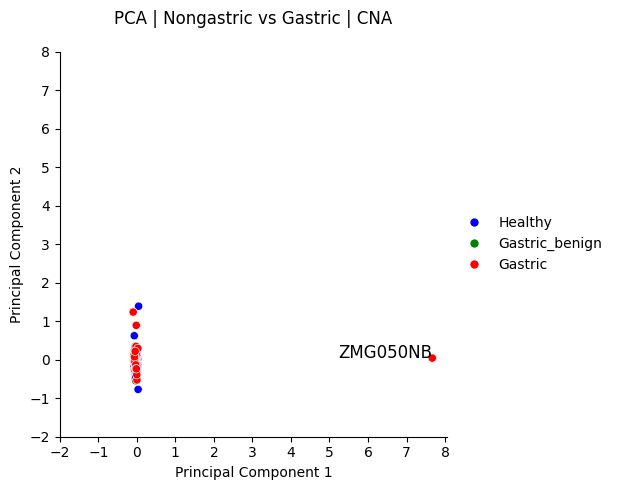

In [ ]:
f='CNA'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-2,9,1],xticks=[-2,9,1],
      save=False,figname='PCA.png'
            )

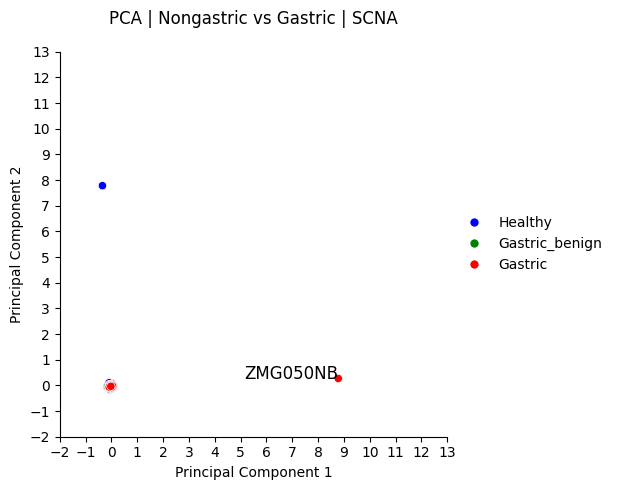

In [ ]:
f='SCNA'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-2,14,1],xticks=[-2,14,1],
      save=False,figname='PCA.png'
            )

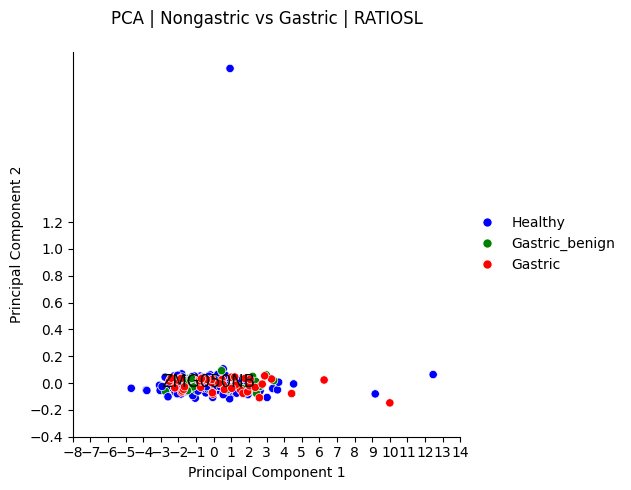

In [ ]:
f='RATIOSL'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-0.4,1.4,0.2],xticks=[-8,15,1],
      save=False,figname='PCA.png'
            )

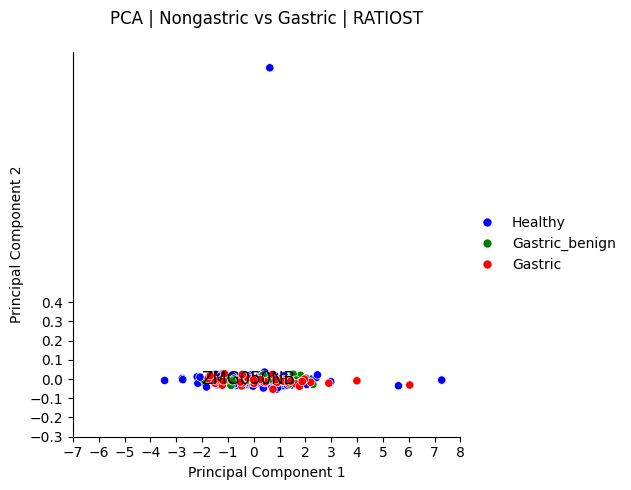

In [ ]:
f='RATIOST'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-0.3,0.5,0.1],xticks=[-7,9,1],
      save=False,figname='PCA.png'
            )

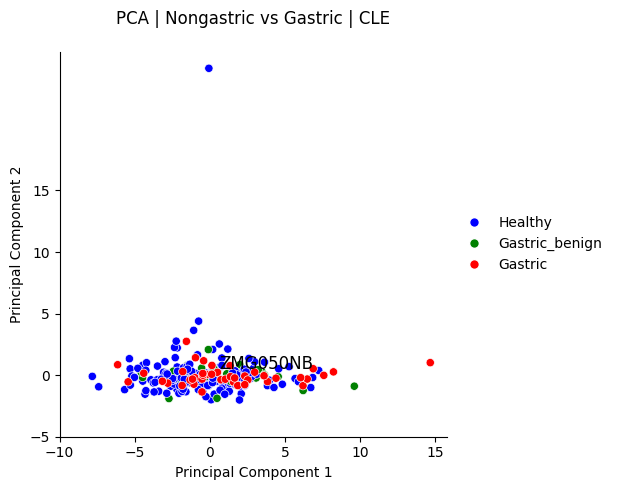

In [ ]:
f='CLE'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-5,20,5],xticks=[-10,20,5],
      save=False,figname='PCA.png'
            )

PCA filter

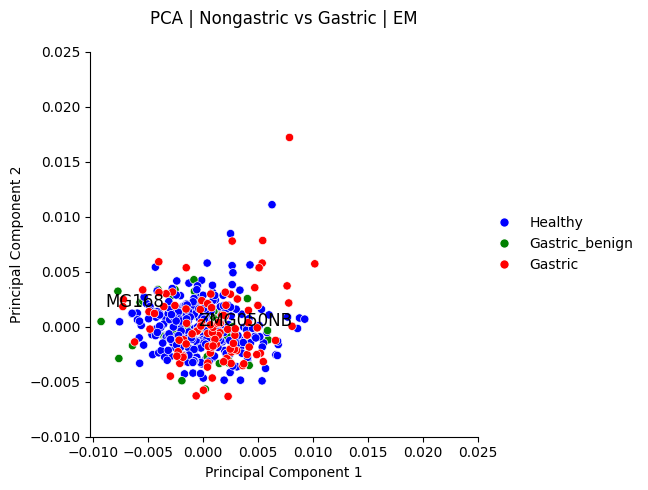

In [ ]:
f='EM'
healthy1=healthy[~healthy.iloc[:, 0].str.contains(special_sample, na=False)]
Nongastric1=pd.concat([healthy1,gastric_benign],axis=0)
PCAsigfea(
        DATA,
        SAMPLES={'Healthy':healthy1,'Gastric':gastric,'Gastric_benign':gastric_benign,'Nongastric':Nongastric1},
        stats_fea=stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        p='Nongastric vs Gastric',
        f=f,
        sig=False,alpha=0.05,
        show_ID=True,IDs=special_samples,
        plot_pct_explain=False,top_pc=2,
        yticks=[-0.01,0.025,0.005],xticks=[-0.01,0.025,0.005],
        save=False,figname='PCA.png'
              )

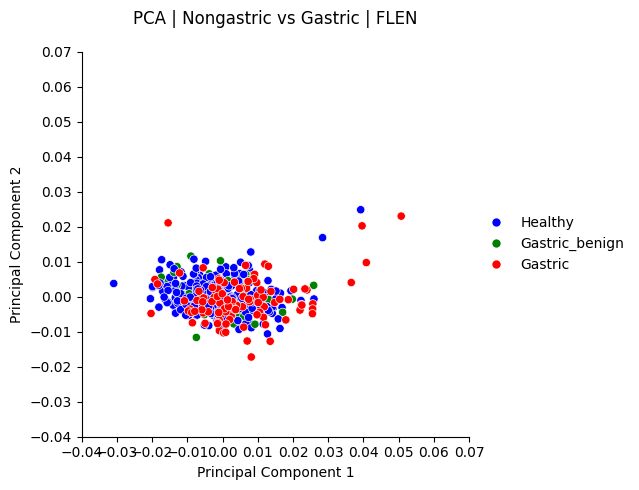

In [ ]:
f='FLEN'
healthy1=healthy[~healthy.iloc[:, 0].str.contains(special_sample, na=False)]
Nongastric1=pd.concat([healthy1,gastric_benign],axis=0)
PCAsigfea(
        DATA,
        SAMPLES={'Healthy':healthy1,'Gastric':gastric,'Gastric_benign':gastric_benign,'Nongastric':Nongastric1},
        stats_fea=stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        p='Nongastric vs Gastric',
        f=f,
        sig=False,alpha=0.05,
        show_ID=True,IDs=[special_sample],
        plot_pct_explain=False,top_pc=2,
        yticks=[-0.04,0.07,0.01],xticks=[-0.04,0.07,0.01],
        save=False,figname='PCA.png'
              )

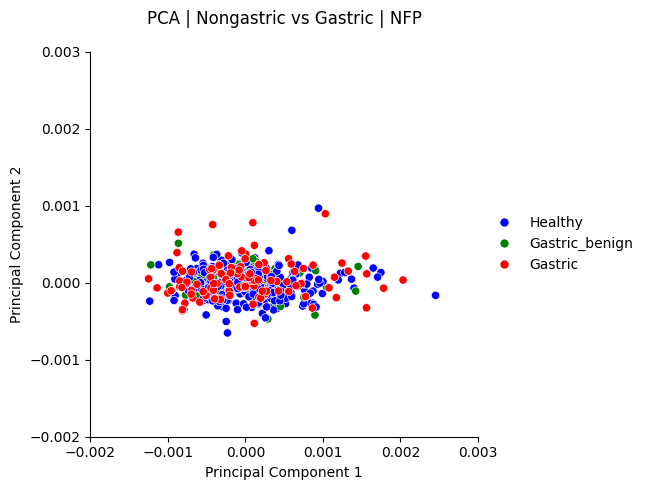

In [ ]:
f='NFP'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES={'Healthy':healthy1,'Gastric':gastric,'Gastric_benign':gastric_benign,'Nongastric':Nongastric1},
      stats_fea=stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=[special_sample],
      plot_pct_explain=False,top_pc=2,
      yticks=[-0.002,0.004,0.001],xticks=[-0.002,0.004,0.001],
      save=False,figname='PCA.png'
            )

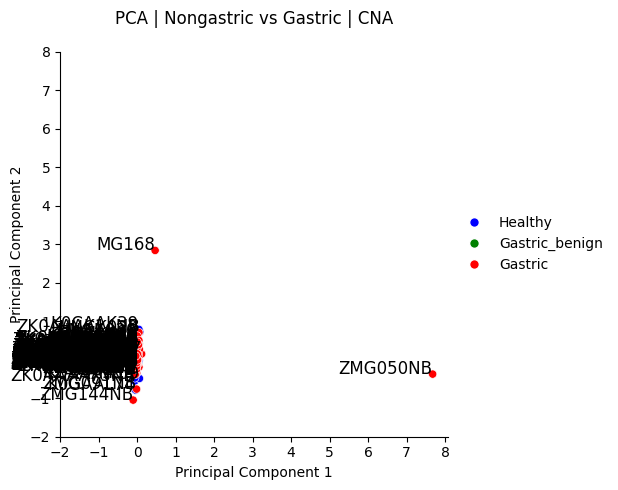

In [ ]:
f='CNA'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES={'Healthy':healthy1,'Gastric':gastric,'Gastric_benign':gastric_benign,'Nongastric':Nongastric1},
      stats_fea=stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=list(set(sample_list_all['SampleID'])-set(special_sample)),
      plot_pct_explain=False,top_pc=2,
      yticks=[-2,9,1],xticks=[-2,9,1],
      save=False,figname='PCA.png'
            )

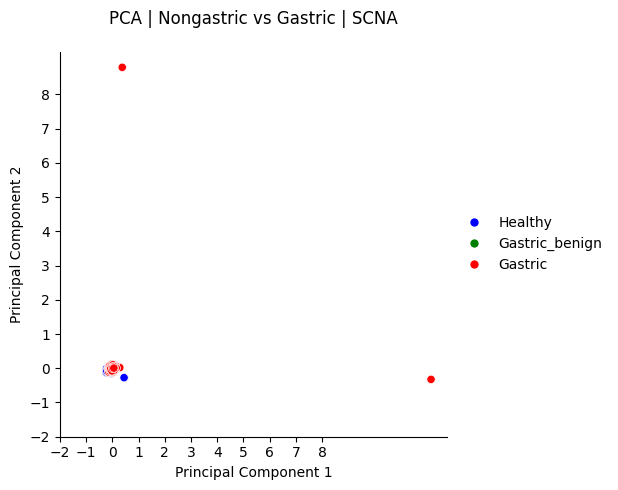

In [ ]:
f='SCNA'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES={'Healthy':healthy1,'Gastric':gastric,'Gastric_benign':gastric_benign,'Nongastric':Nongastric1},
      stats_fea=stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=[special_sample],
      plot_pct_explain=False,top_pc=2,
      yticks=[-2,9,1],xticks=[-2,9,1],
      save=False,figname='PCA.png'
            )

t-SNE

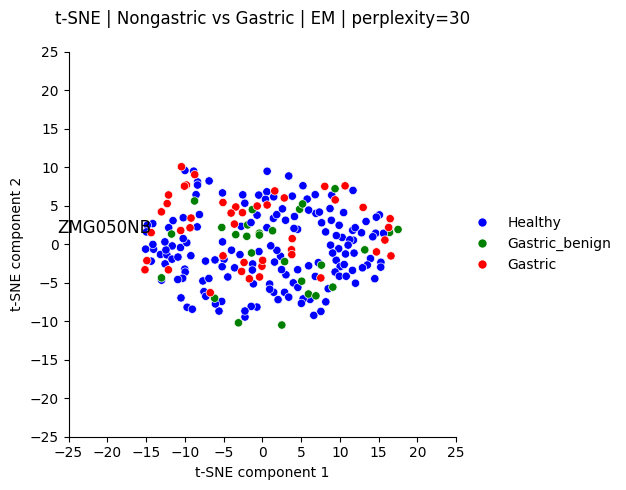

In [ ]:
f='EM'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-25,30,5],
    xticks=[-25,30,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

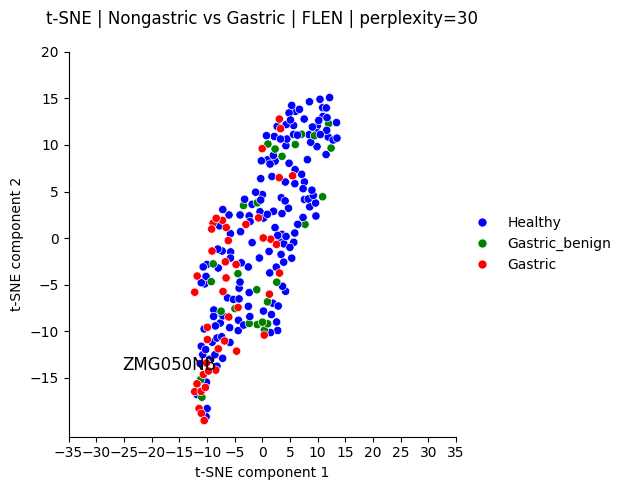

In [ ]:
f='FLEN'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-15,25,5],
    xticks=[-35,40,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

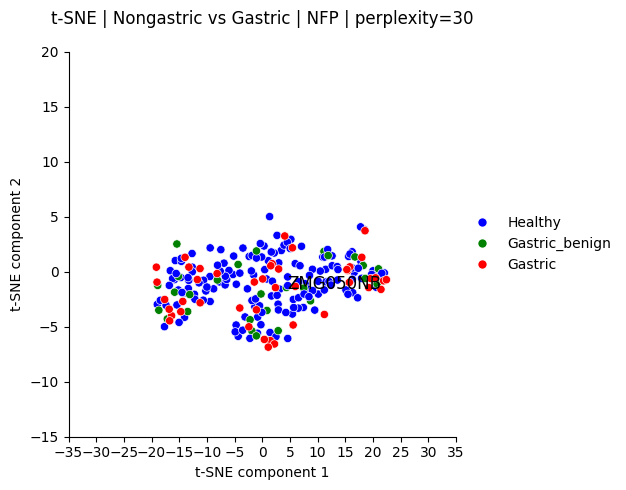

In [ ]:
f='NFP'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-15,25,5],
    xticks=[-35,40,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

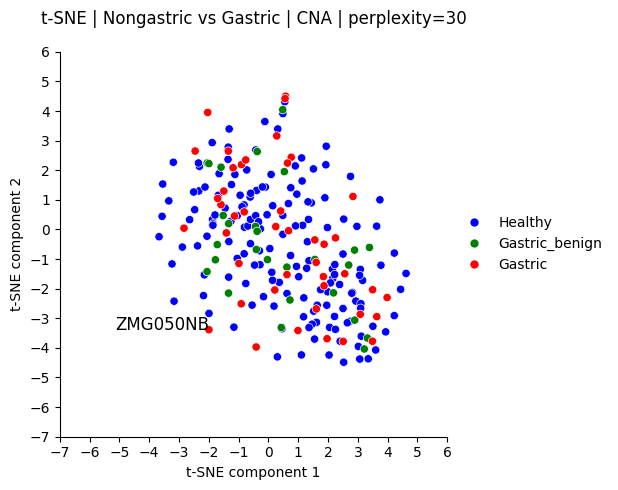

In [ ]:
f='CNA'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-7,7,1],
    xticks=[-7,7,1],
    perplexity=30,
    save=False,
    figname='TSNE.png')

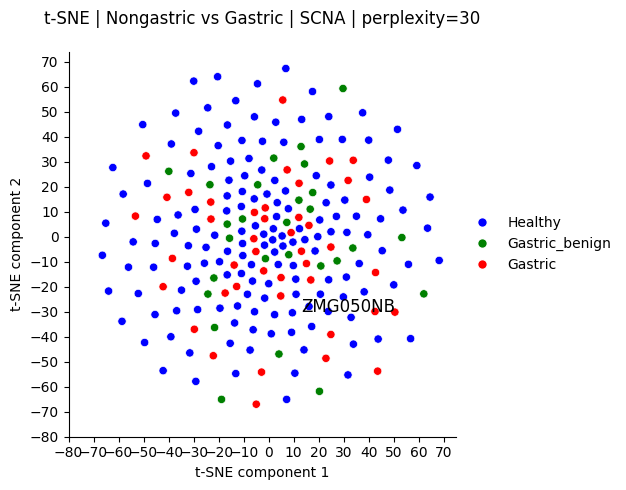

In [ ]:
f='SCNA'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-80,80,10],
    xticks=[-80,80,10],
    perplexity=30,
    save=False,
    figname='TSNE.png')

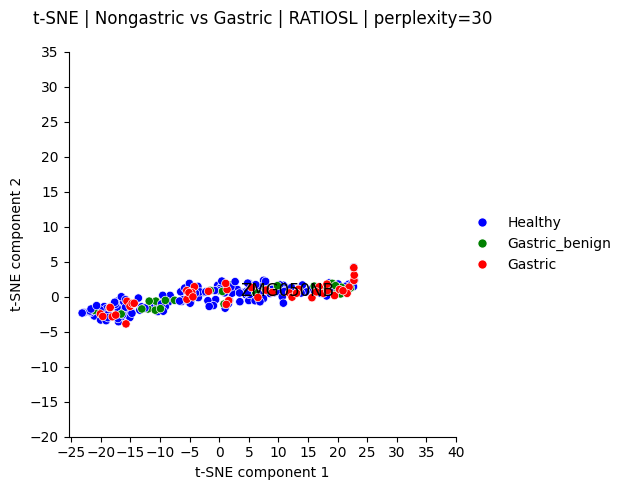

In [ ]:
f='RATIOSL'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-20,40,5],
    xticks=[-25,45,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

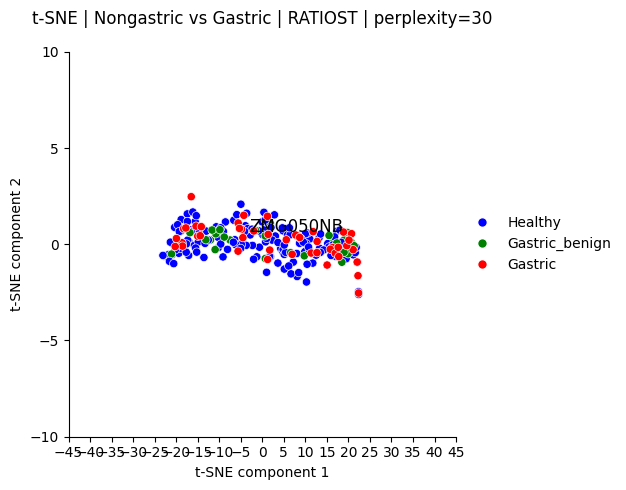

In [ ]:
f='RATIOST'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-10,15,5],
    xticks=[-45,50,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

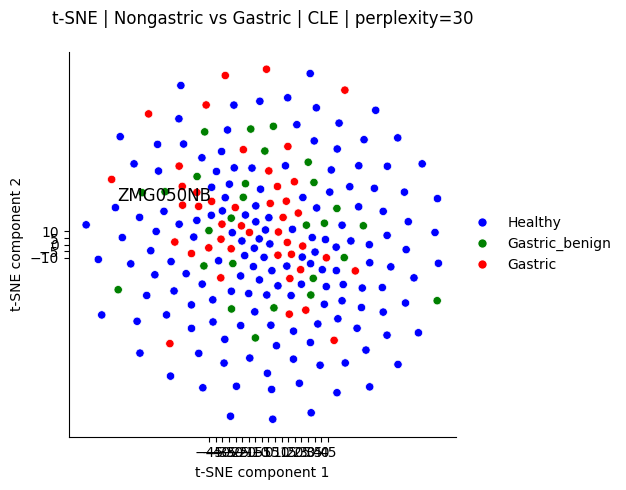

In [ ]:
f='CLE'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-10,15,5],
    xticks=[-45,50,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

UMAP

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


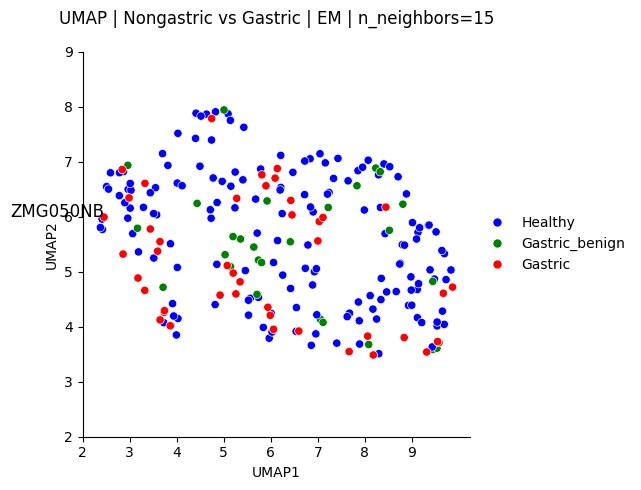

In [ ]:
f='EM'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[2,10,1],
        xticks=[2,10,1],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


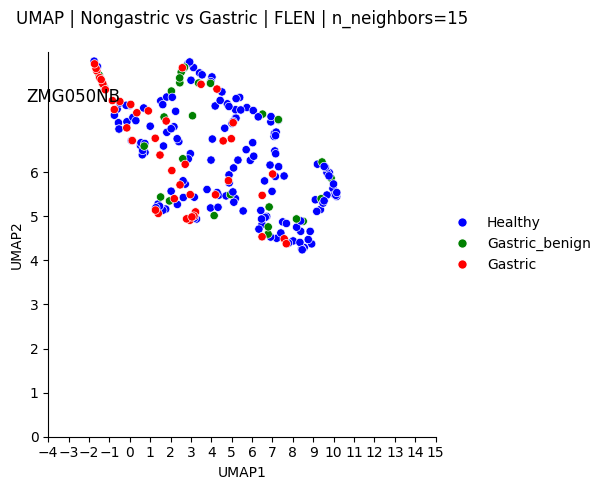

In [ ]:
f='FLEN'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[0,7,1],
        xticks=[-4,16,1],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


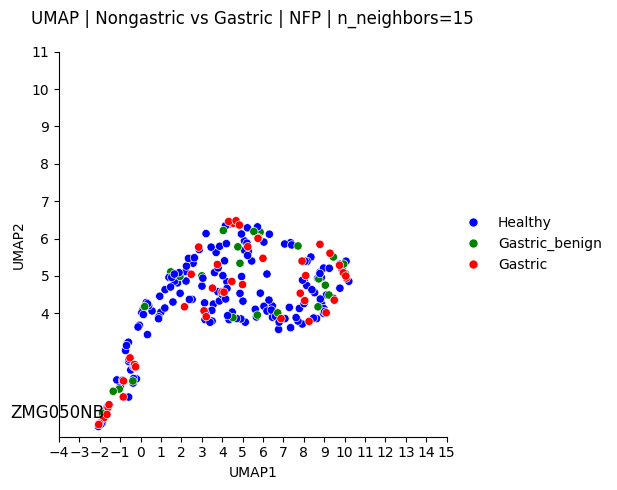

In [ ]:
f='NFP'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[4,12,1],
        xticks=[-4,16,1],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


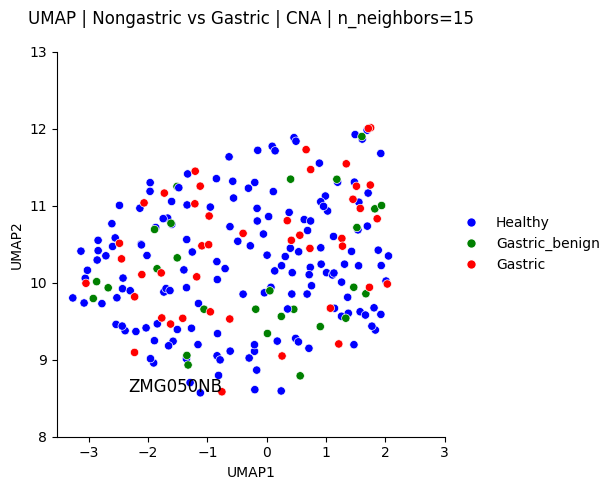

In [ ]:
f='CNA'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[8,14,1],
        xticks=[-3,4,1],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


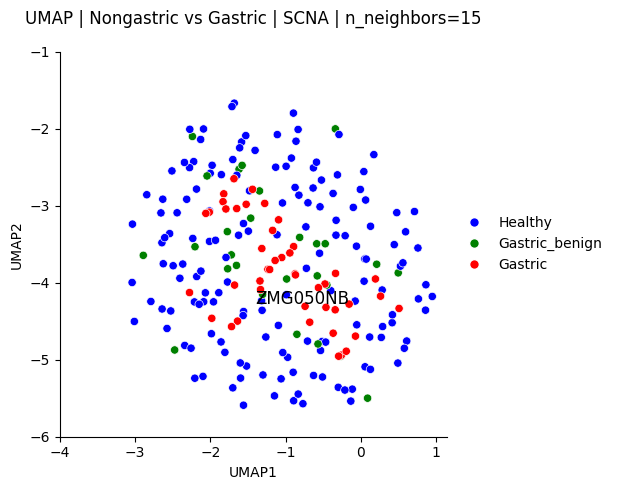

In [ ]:
f='SCNA'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[-6,0,1],
        xticks=[-4,2,1],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


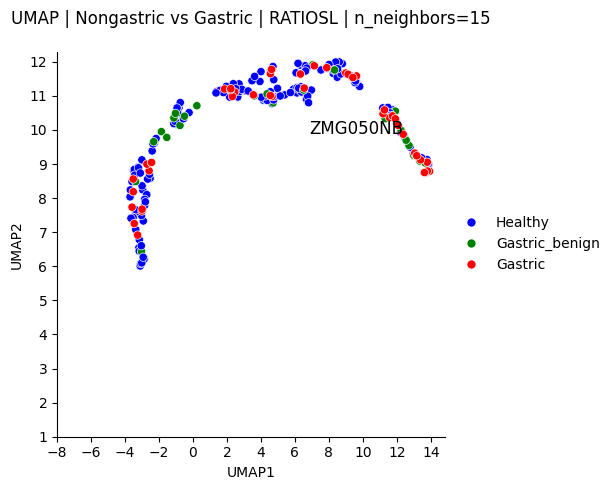

In [ ]:
f='RATIOSL'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[1,13,1],
        xticks=[-8,16,2],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


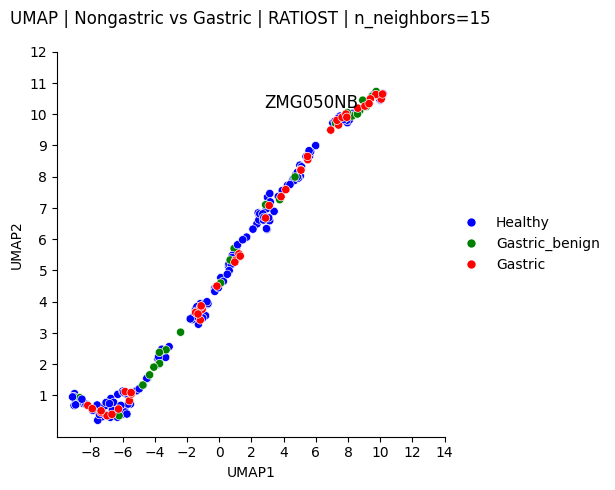

In [ ]:
f='RATIOST'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[1,13,1],
        xticks=[-8,16,2],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


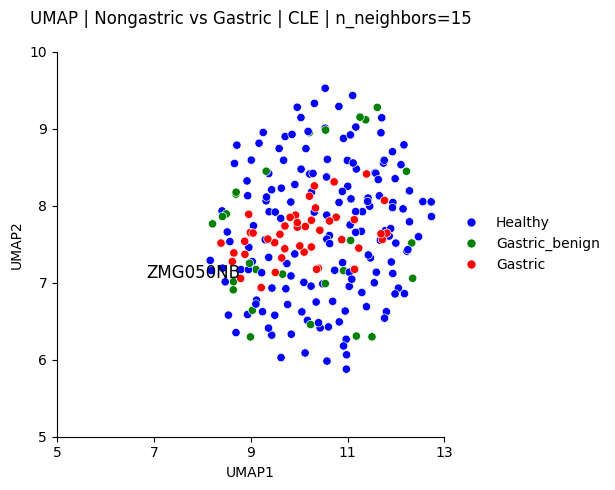

In [ ]:
f='CLE'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[5,11,1],
        xticks=[5,14,2],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

LDA

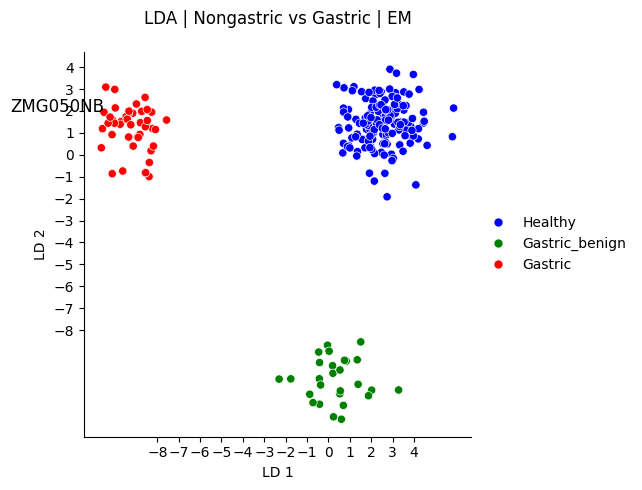

In [ ]:
f='EM'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-8,5,1],xticks=[-8,5,1],
              save=False,figname='LDA.png'
              )

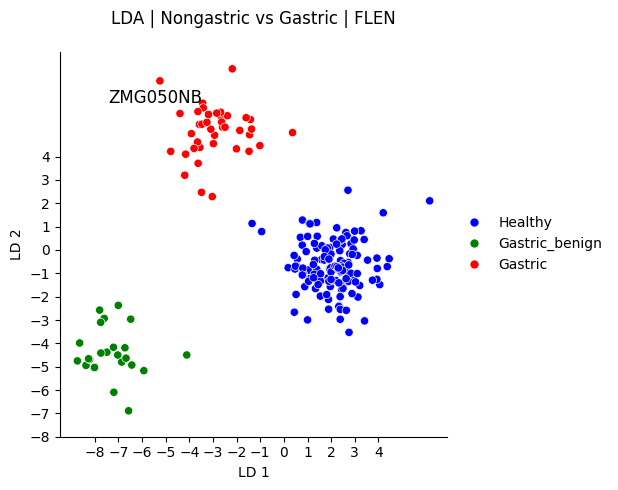

In [ ]:
f='FLEN'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-8,5,1],xticks=[-8,5,1],
              save=False,figname='LDA.png'
              )

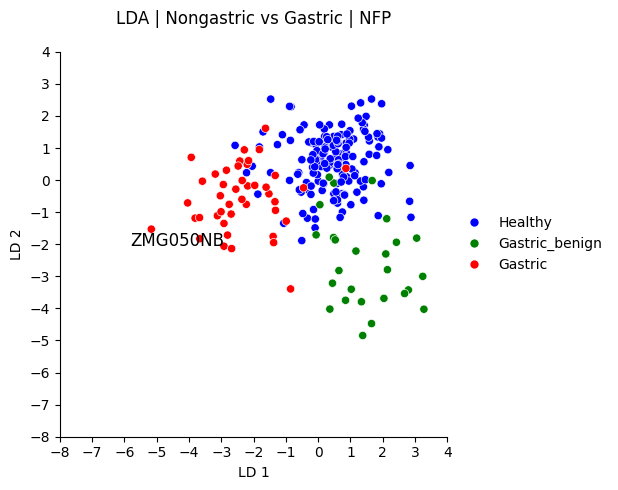

In [ ]:
f='NFP'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-8,5,1],xticks=[-8,5,1],
              save=False,figname='LDA.png'
              )

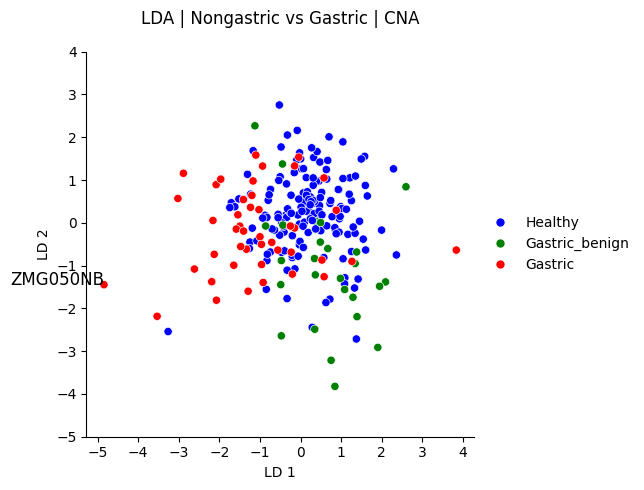

In [ ]:
f='CNA'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-5,5,1],xticks=[-5,5,1],
              save=False,figname='LDA.png'
              )

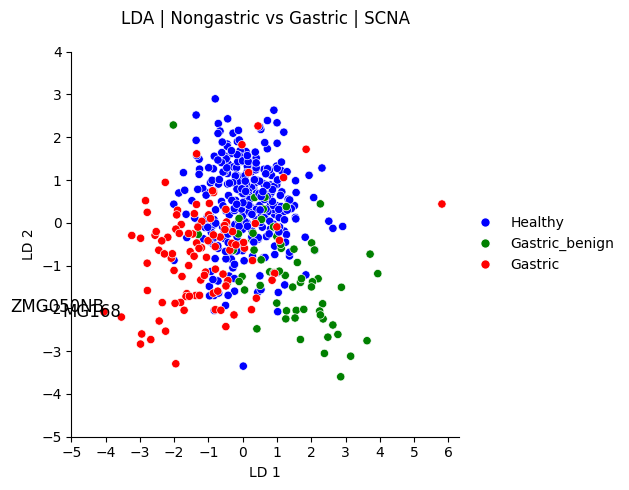

In [ ]:
f='SCNA'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-5,5,1],xticks=[-5,7,1],
              save=False,figname='LDA.png'
              )

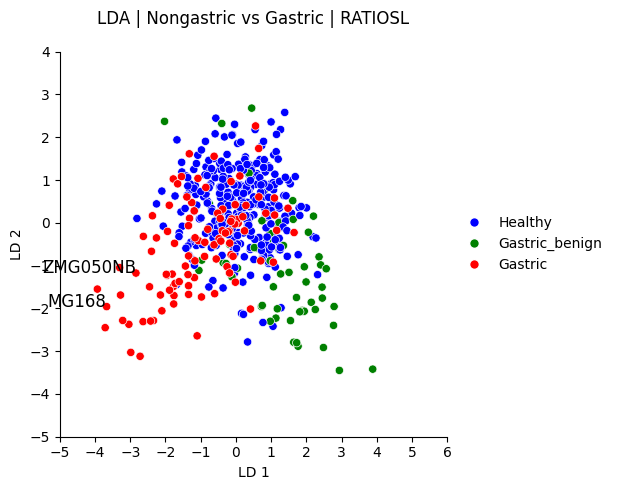

In [ ]:
f='RATIOSL'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-5,5,1],xticks=[-5,7,1],
              save=False,figname='LDA.png'
              )

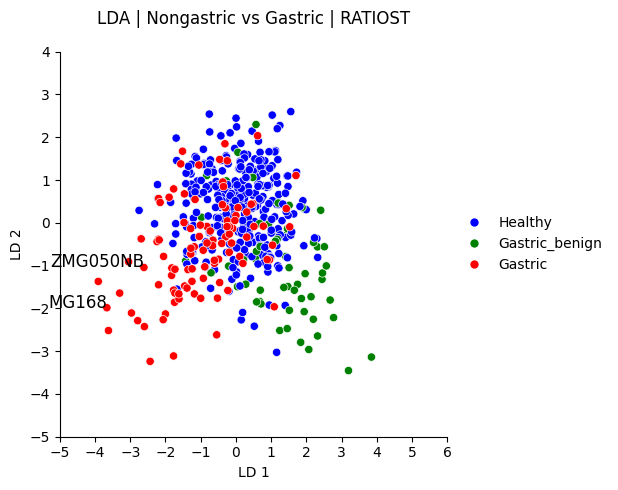

In [ ]:
f='RATIOST'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-5,5,1],xticks=[-5,7,1],
              save=False)

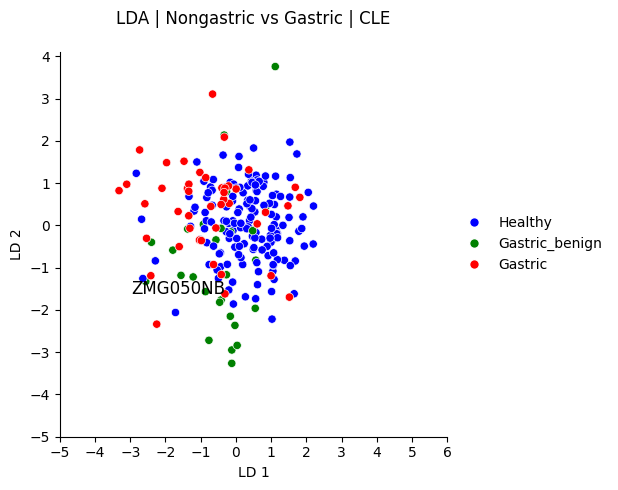

In [ ]:
f='CLE'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-5,5,1],xticks=[-5,7,1],
              save=False)